Pure pursuit path tracking simulation start


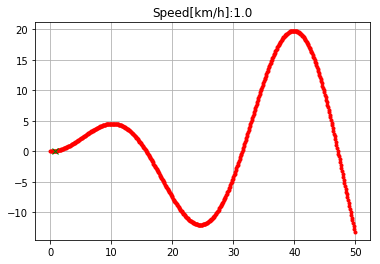

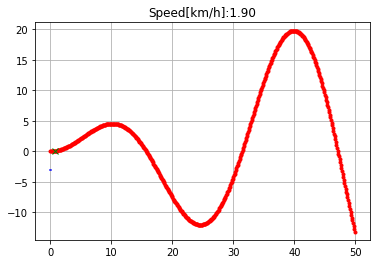

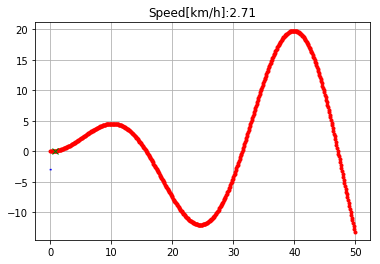

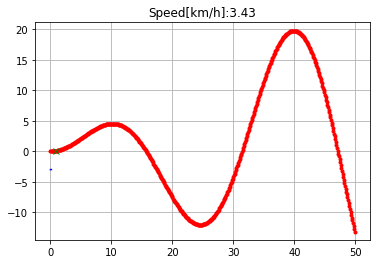

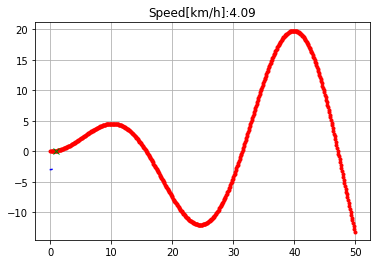

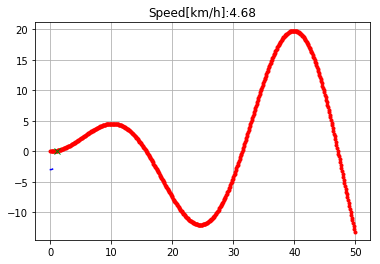

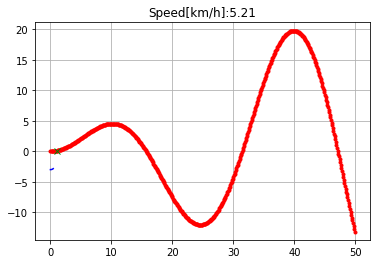

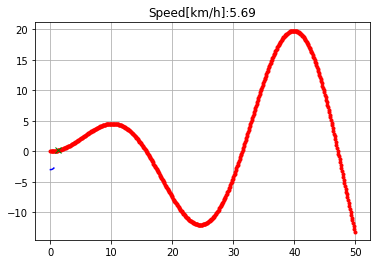

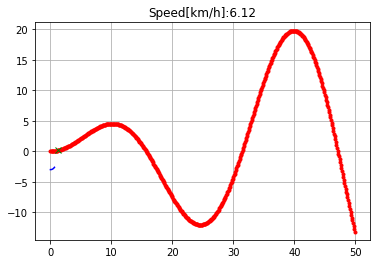

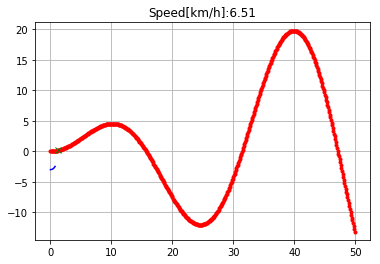

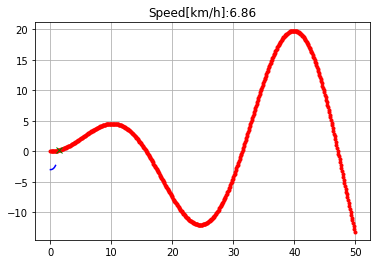

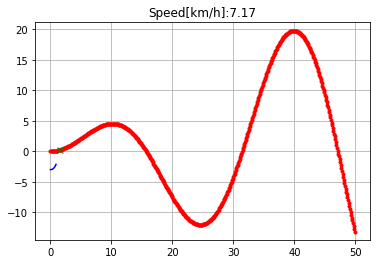

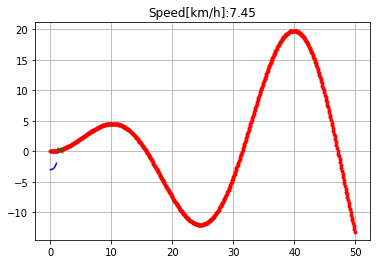

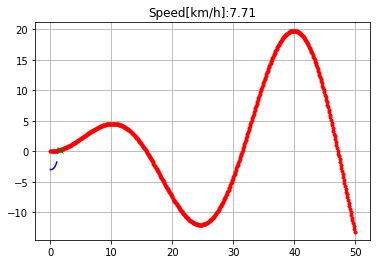

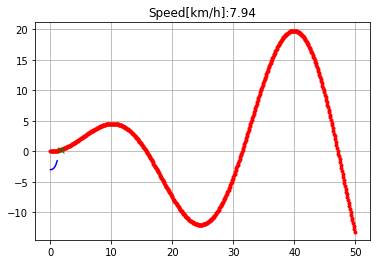

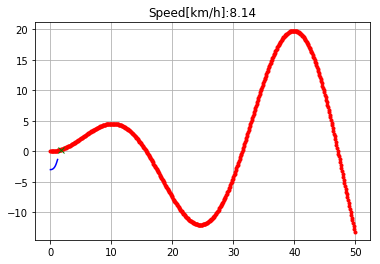

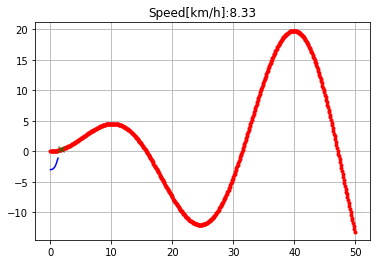

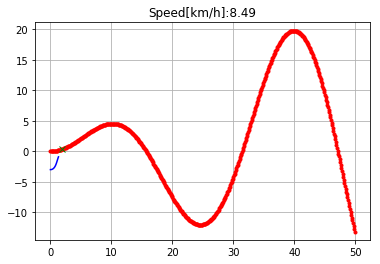

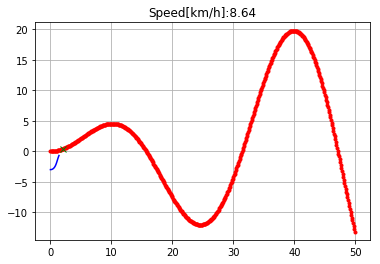

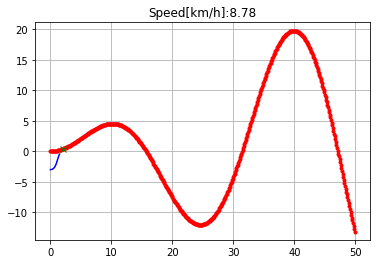

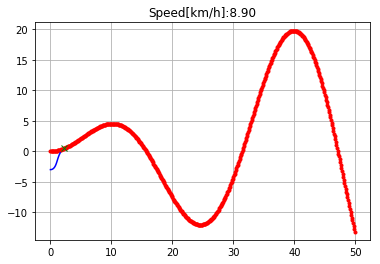

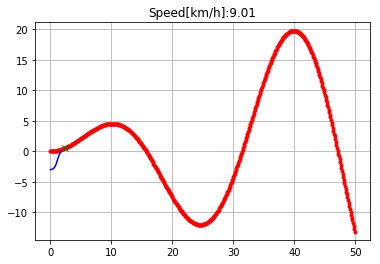

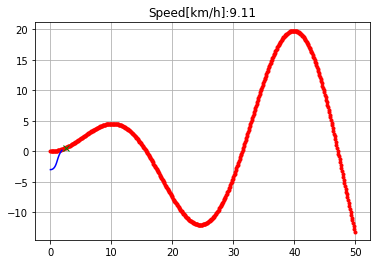

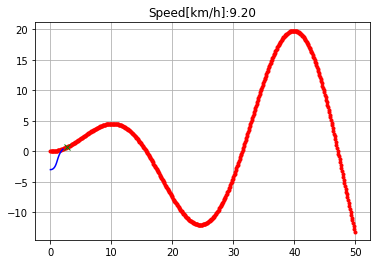

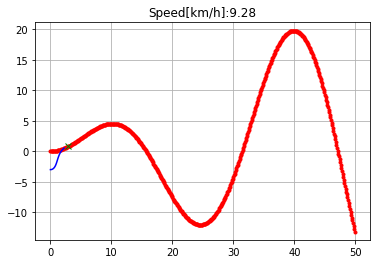

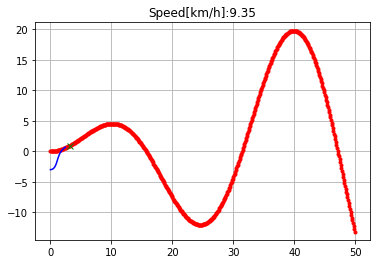

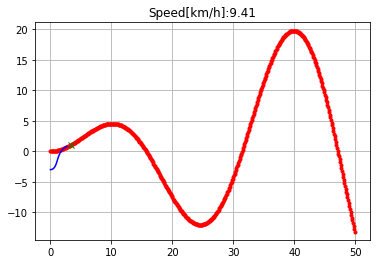

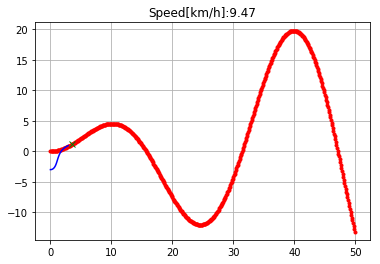

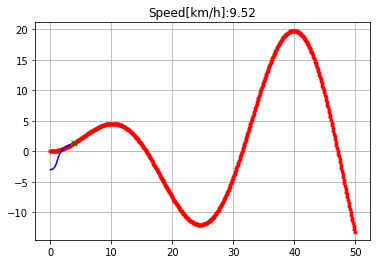

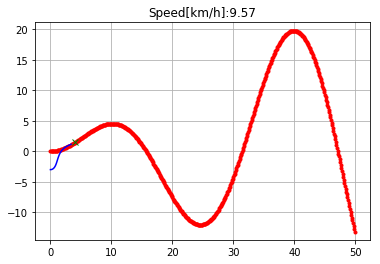

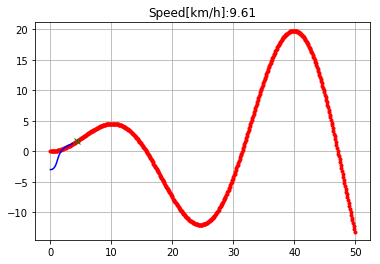

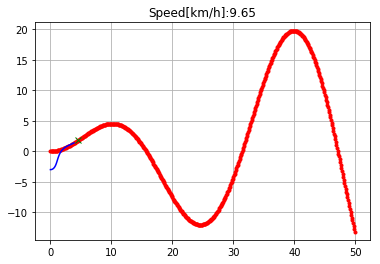

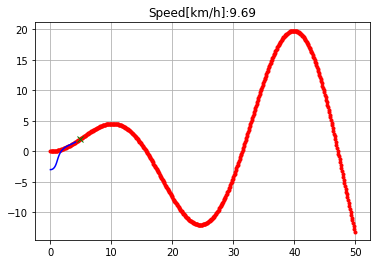

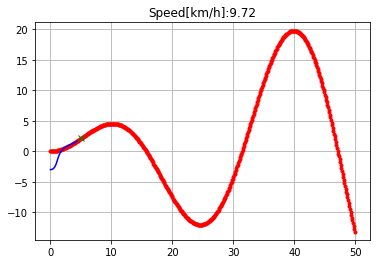

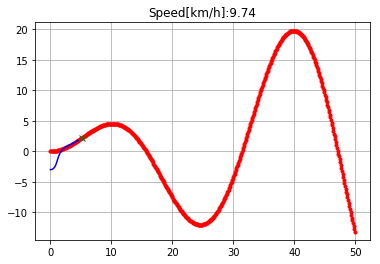

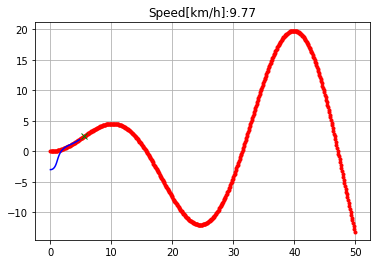

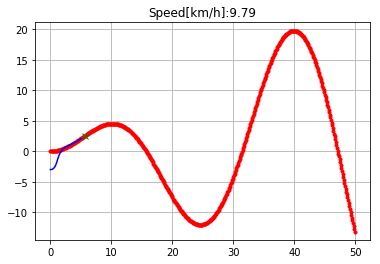

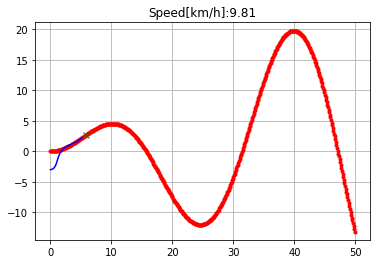

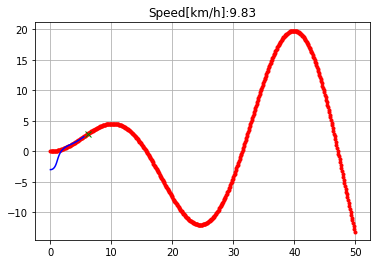

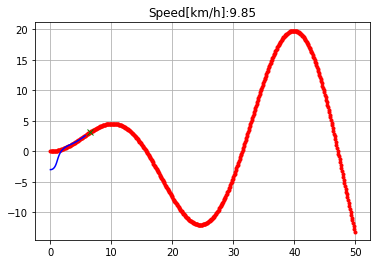

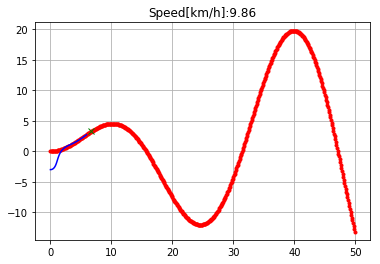

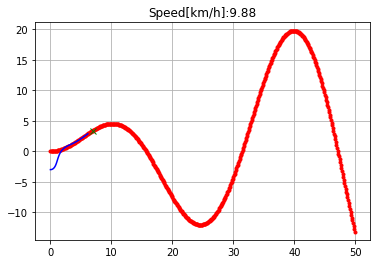

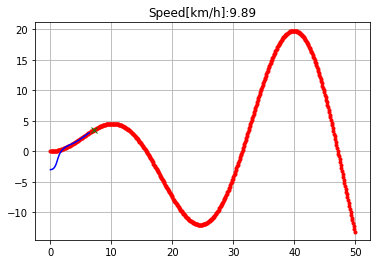

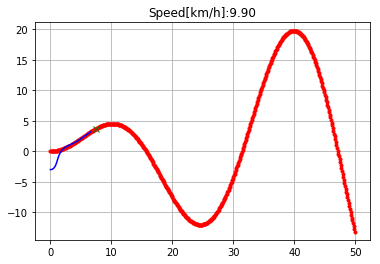

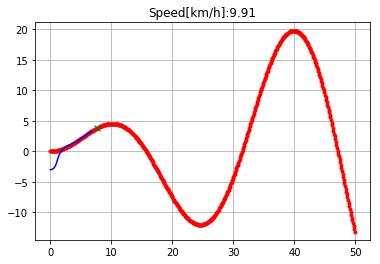

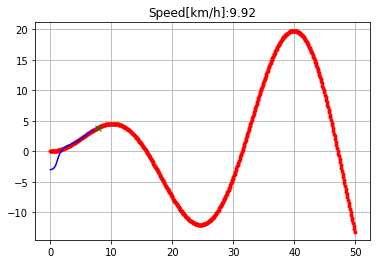

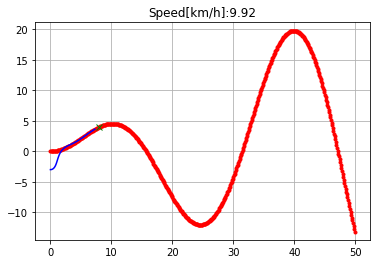

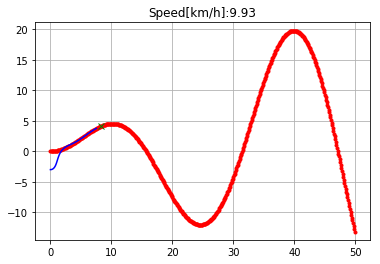

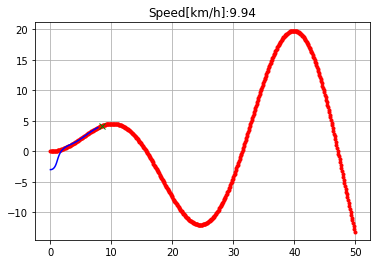

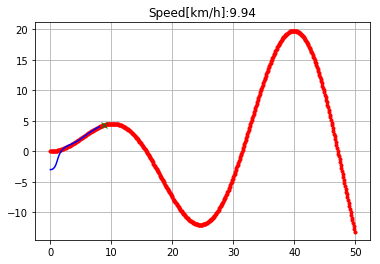

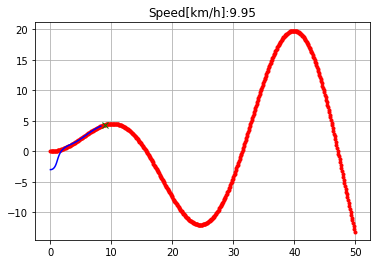

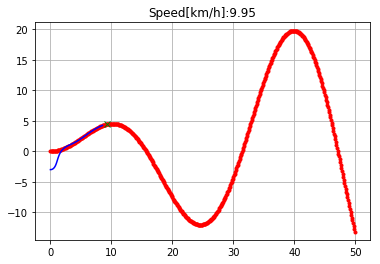

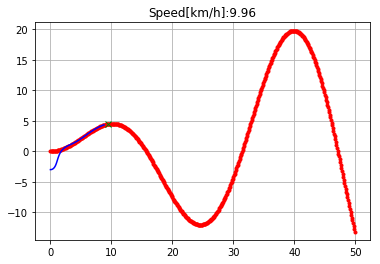

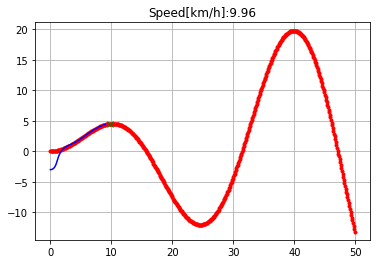

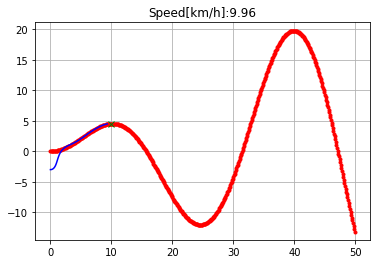

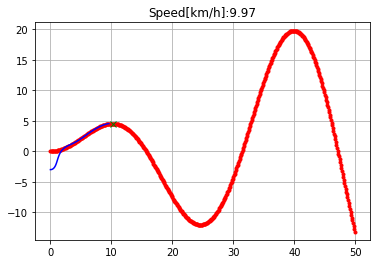

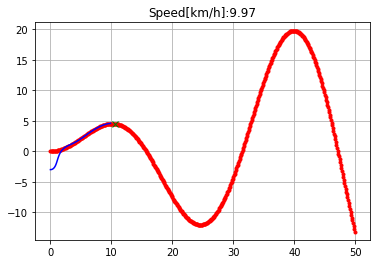

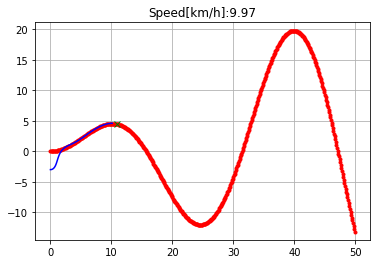

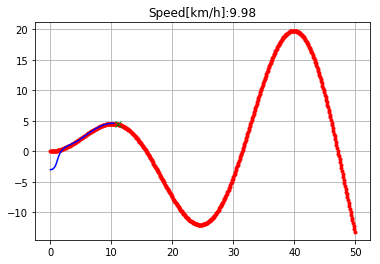

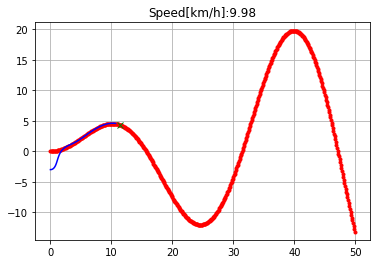

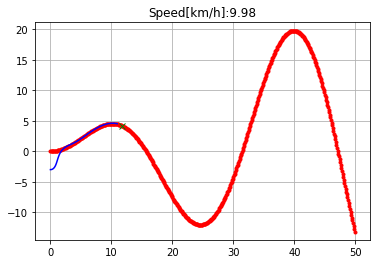

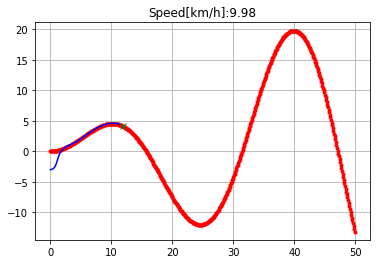

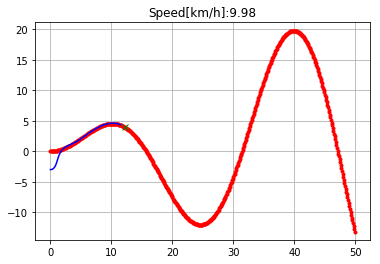

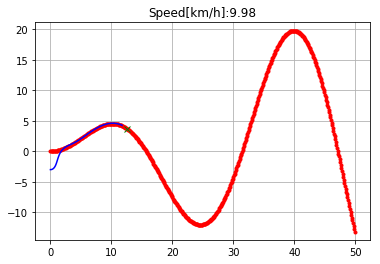

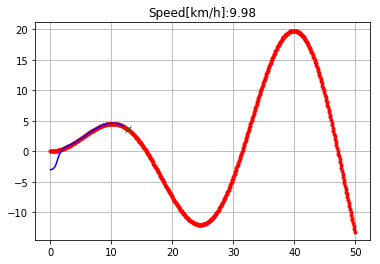

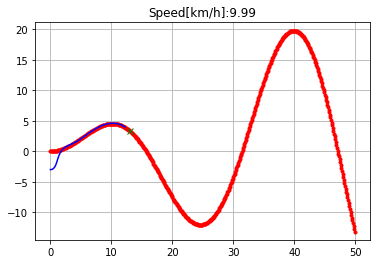

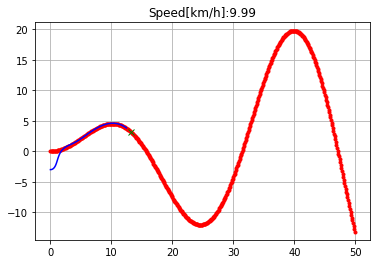

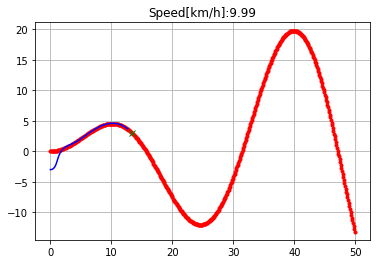

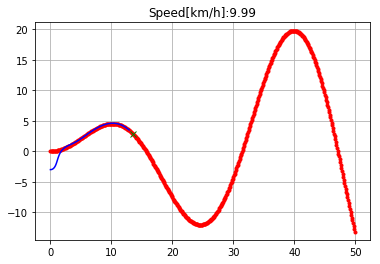

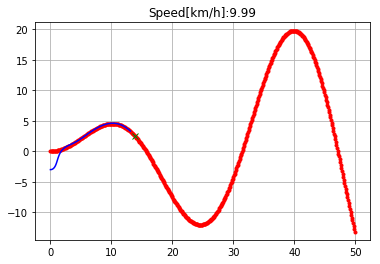

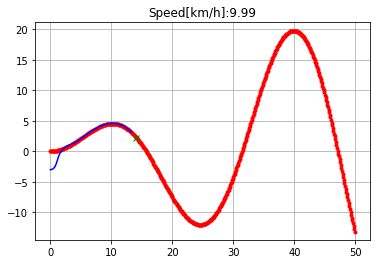

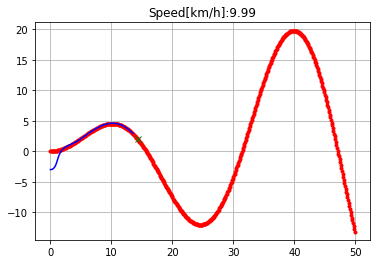

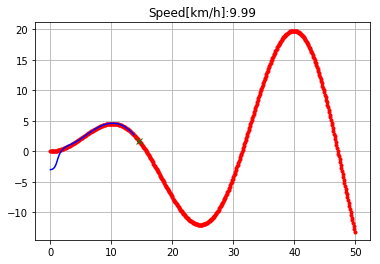

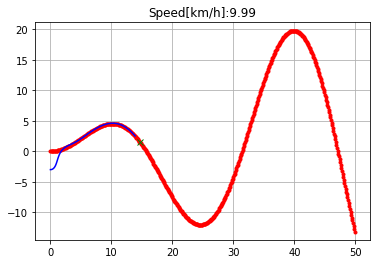

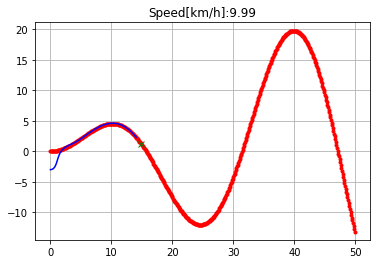

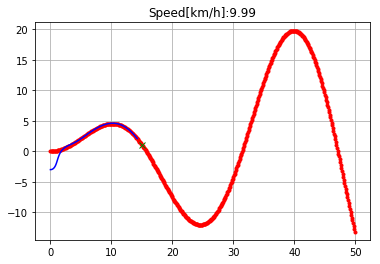

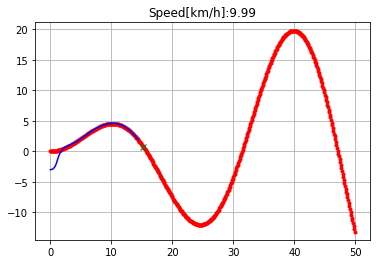

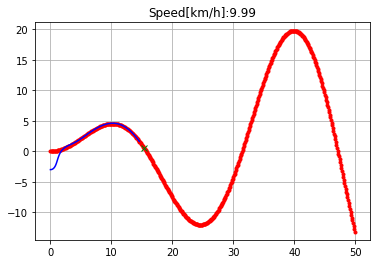

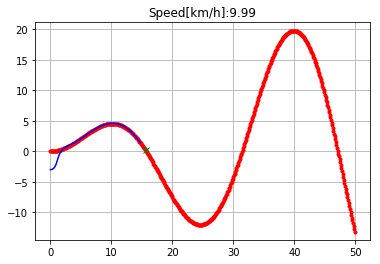

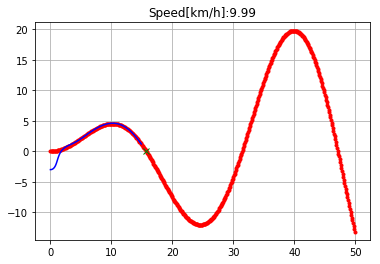

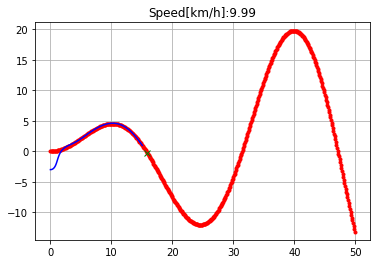

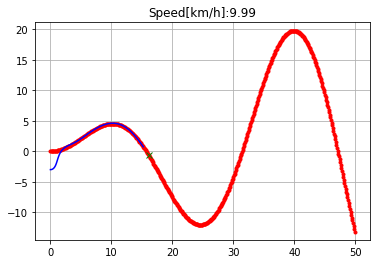

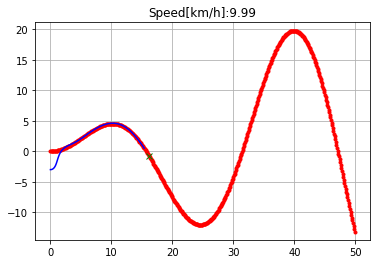

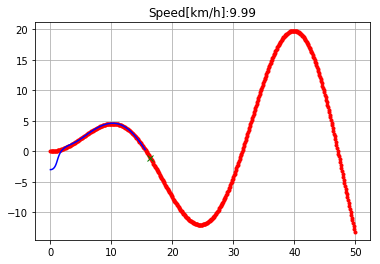

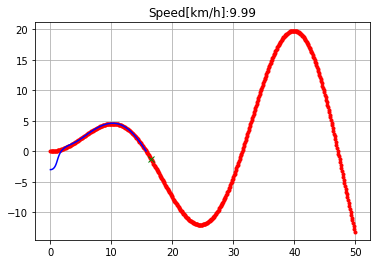

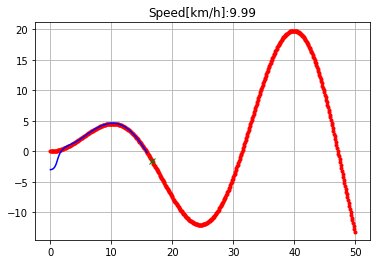

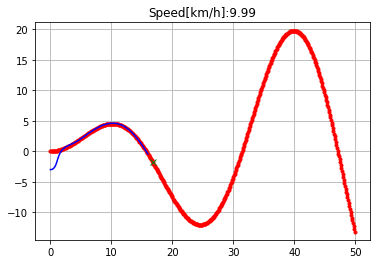

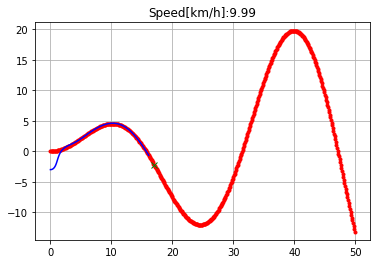

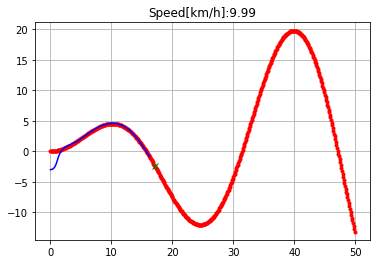

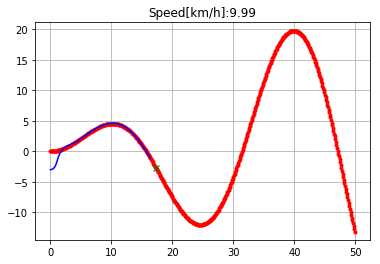

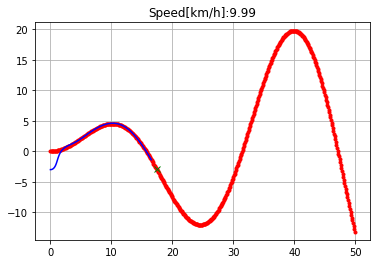

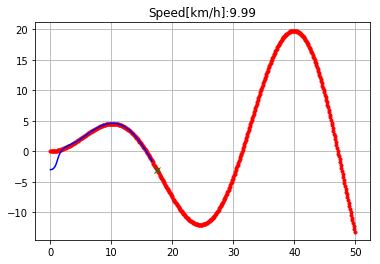

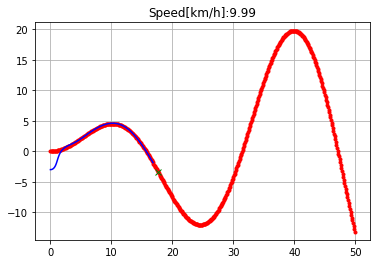

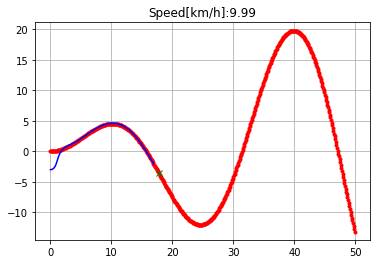

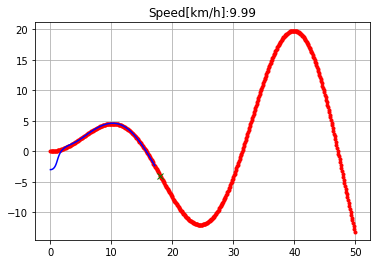

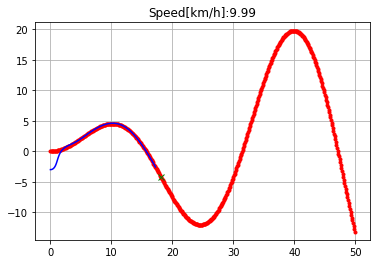

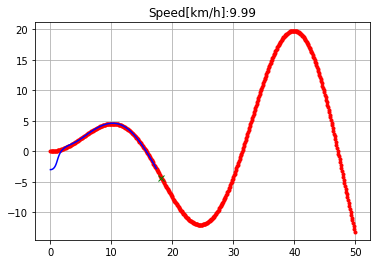

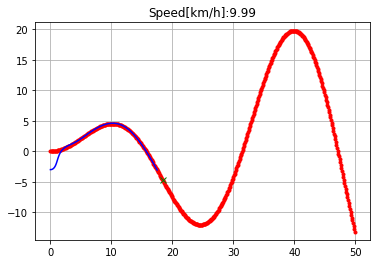

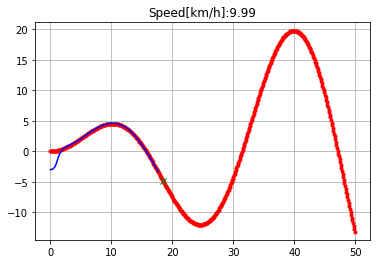

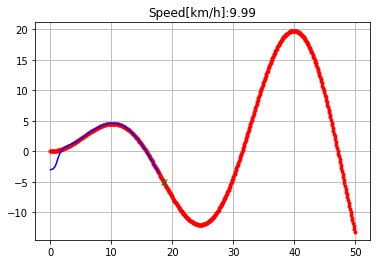

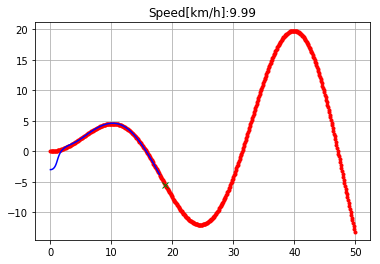

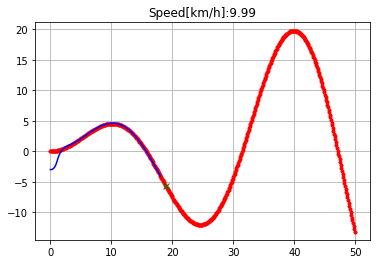

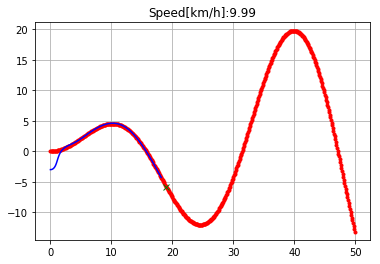

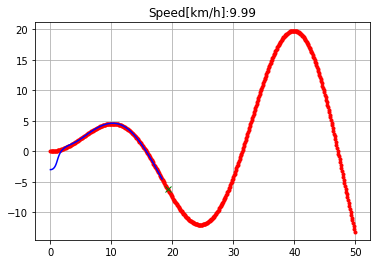

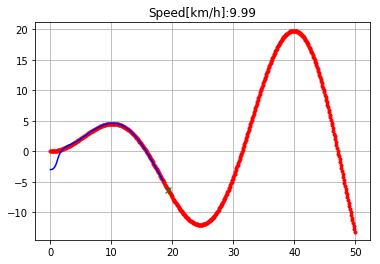

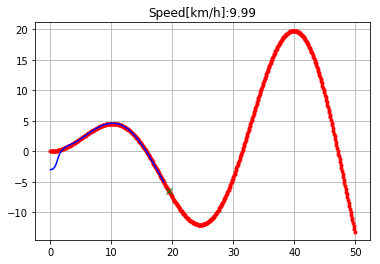

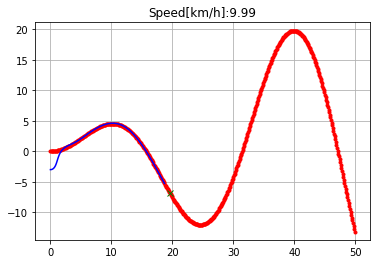

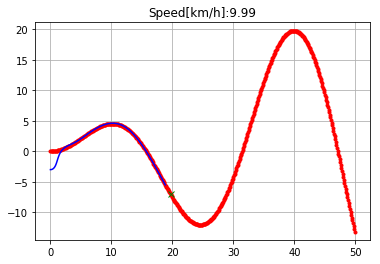

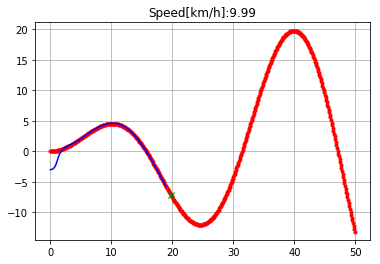

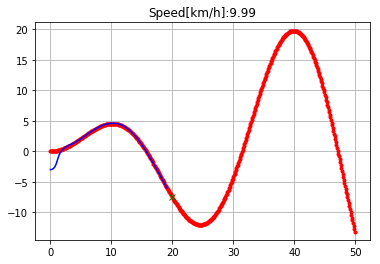

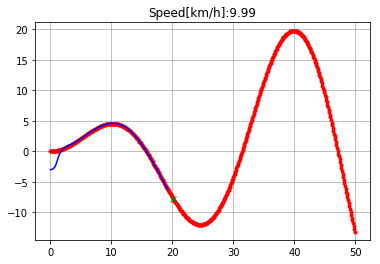

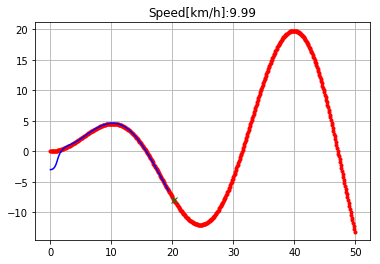

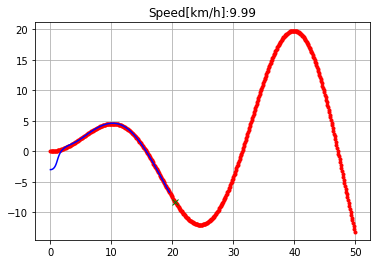

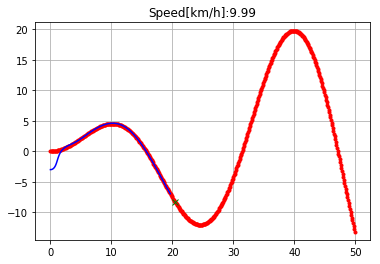

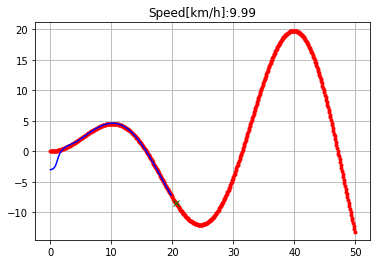

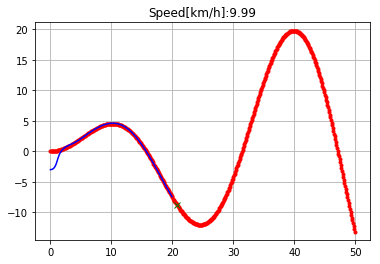

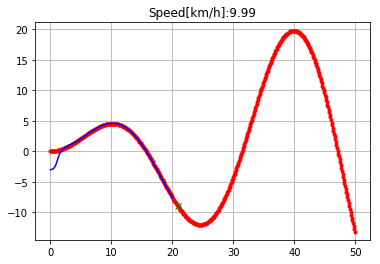

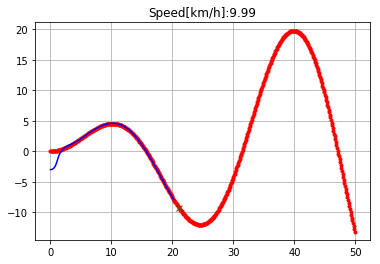

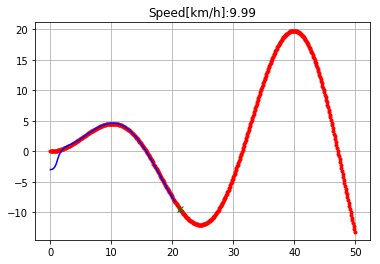

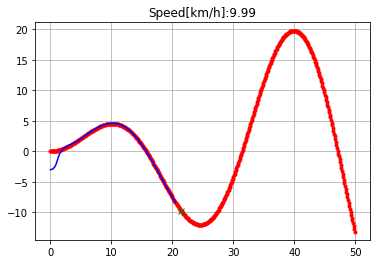

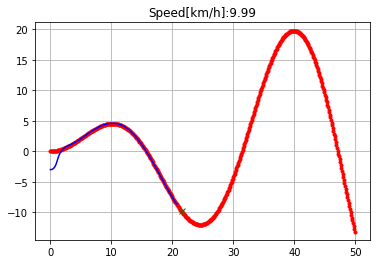

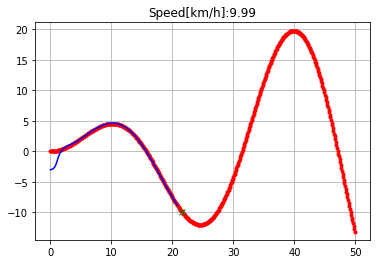

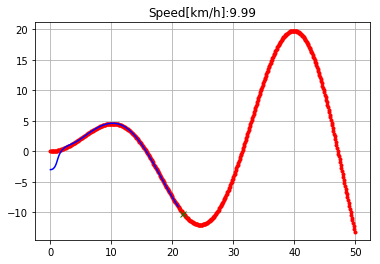

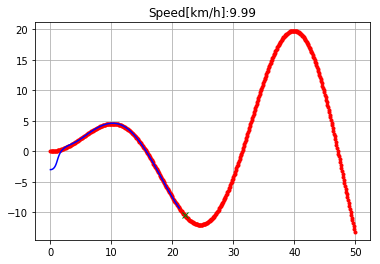

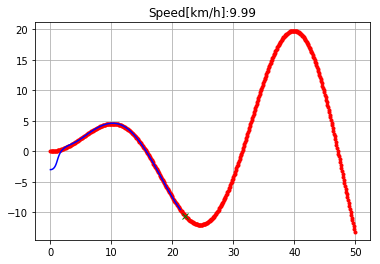

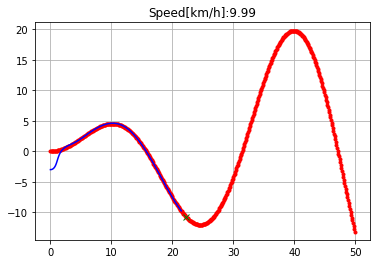

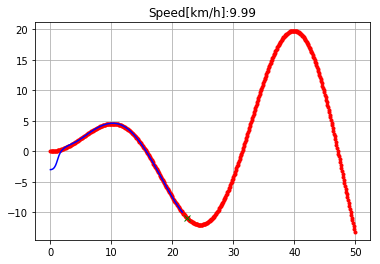

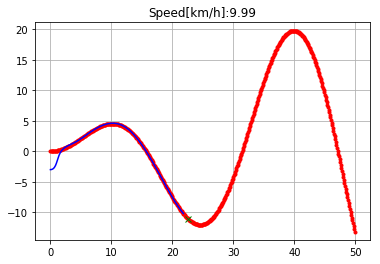

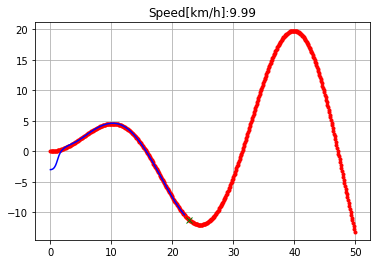

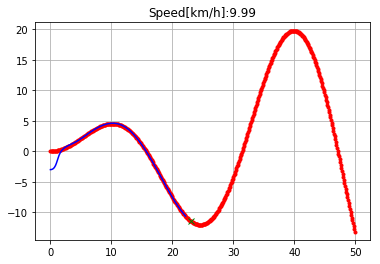

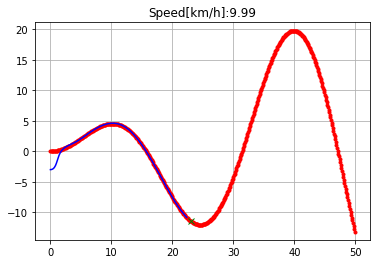

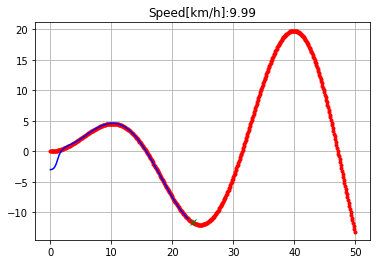

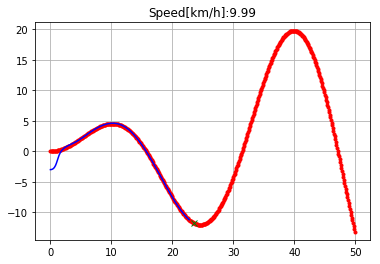

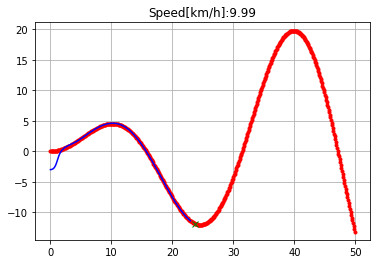

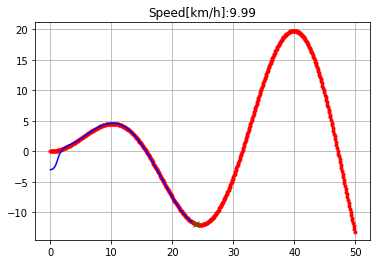

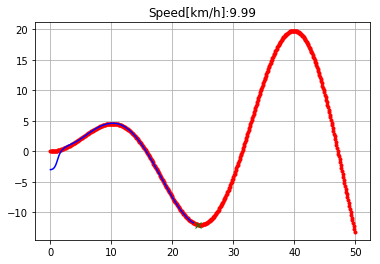

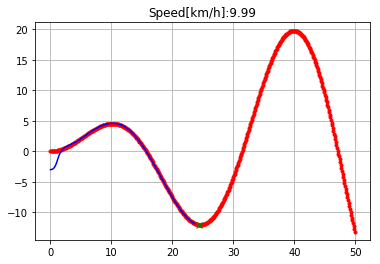

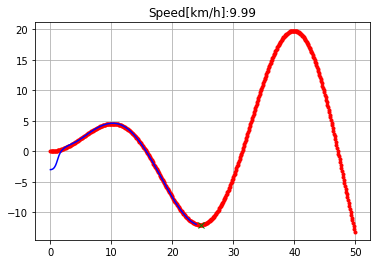

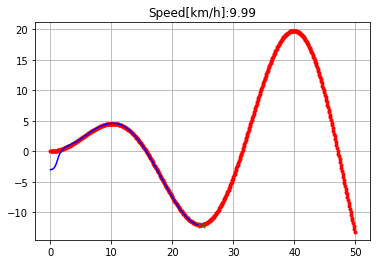

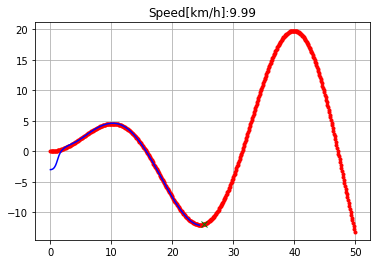

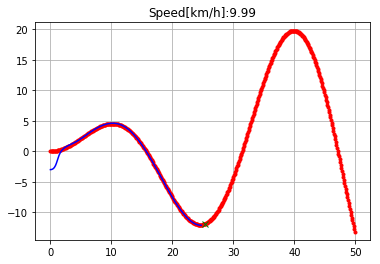

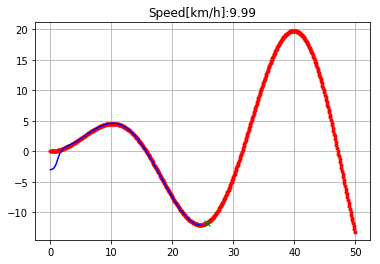

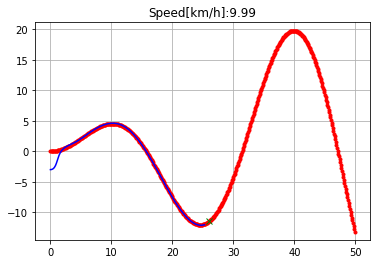

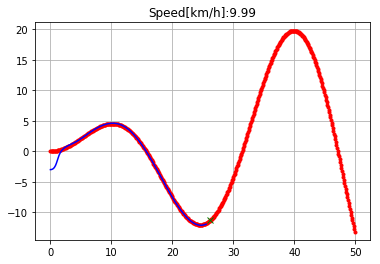

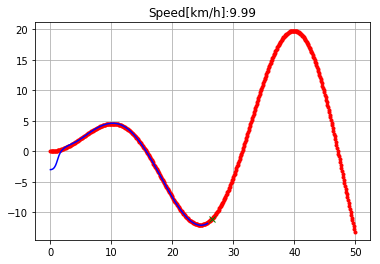

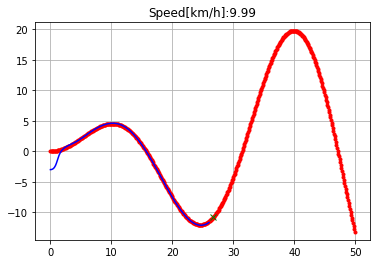

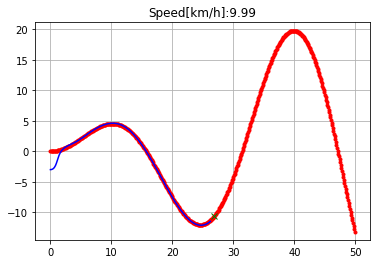

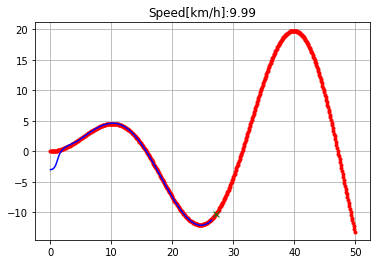

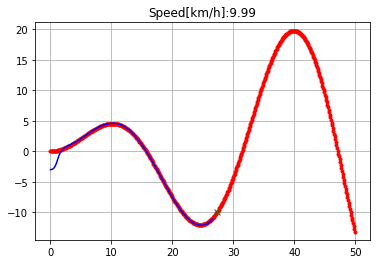

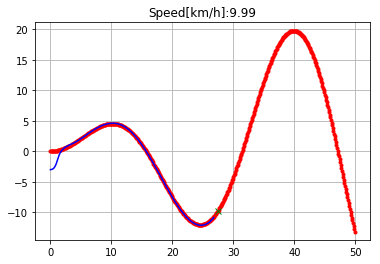

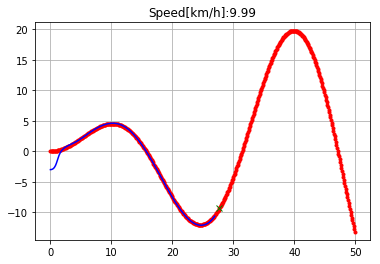

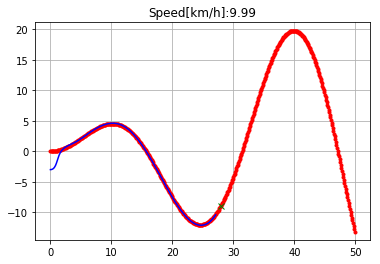

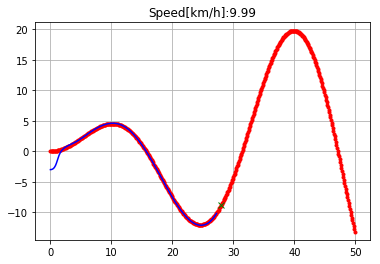

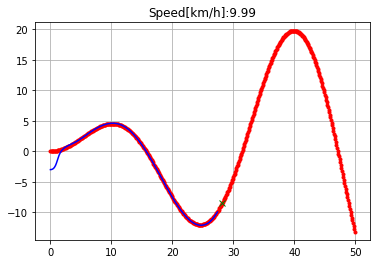

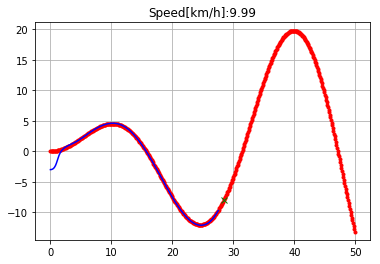

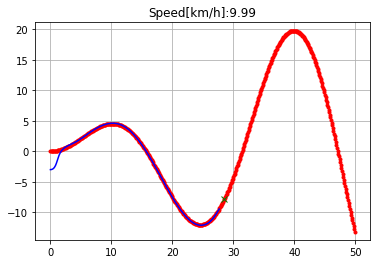

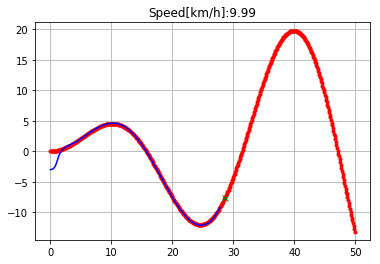

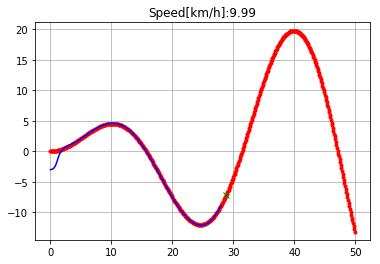

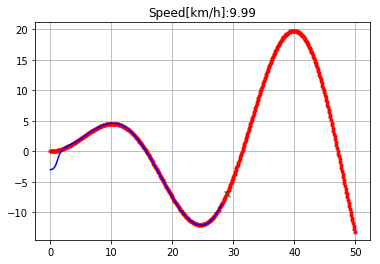

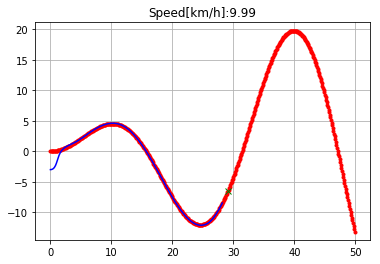

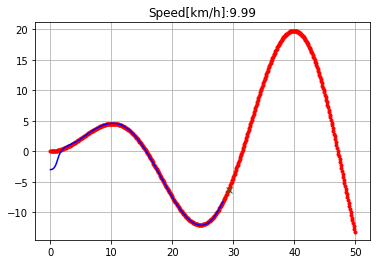

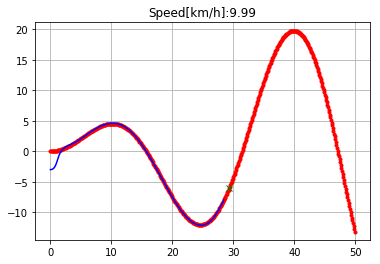

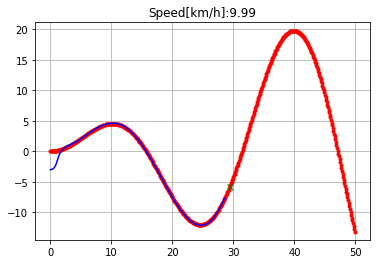

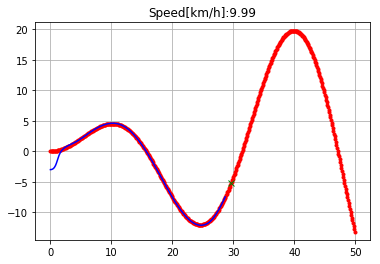

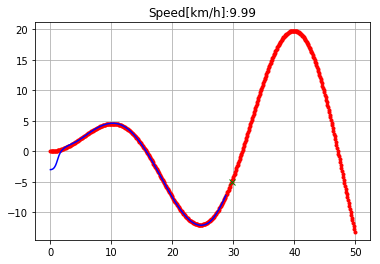

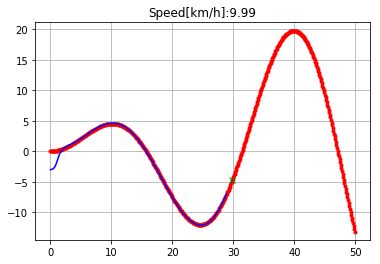

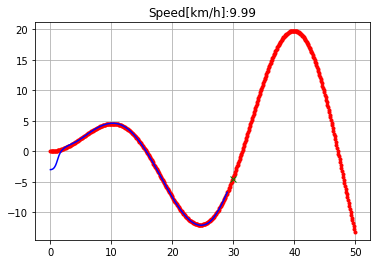

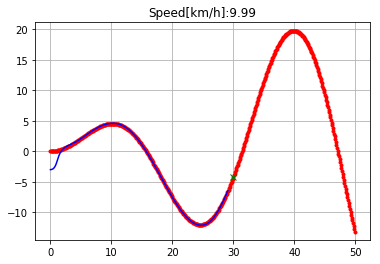

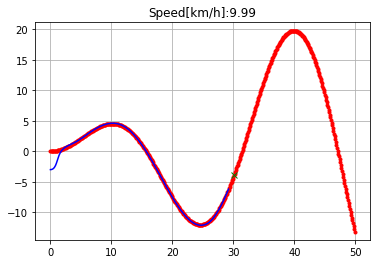

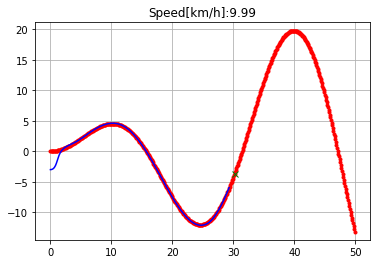

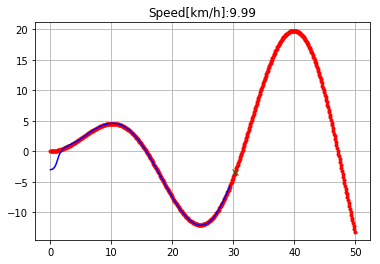

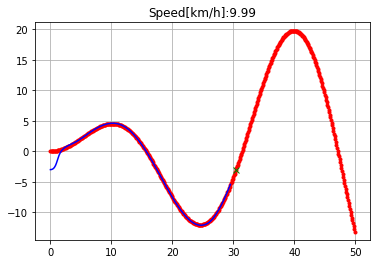

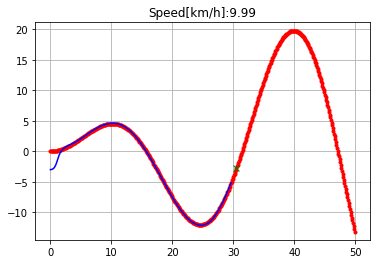

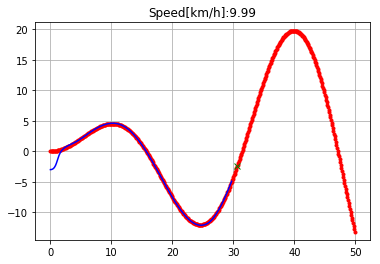

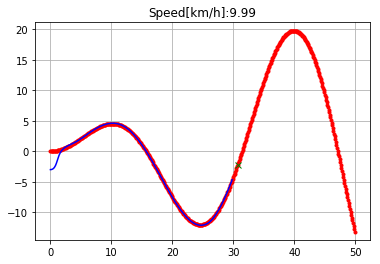

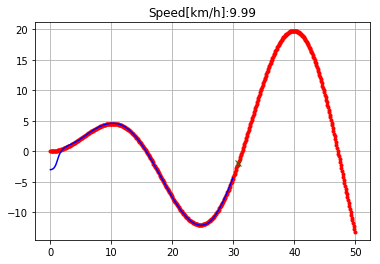

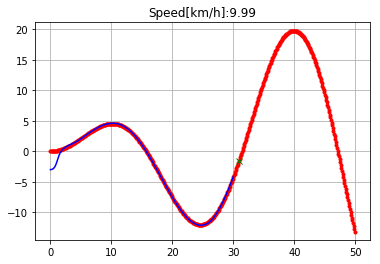

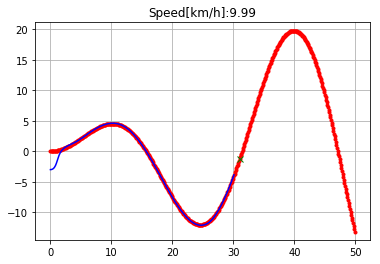

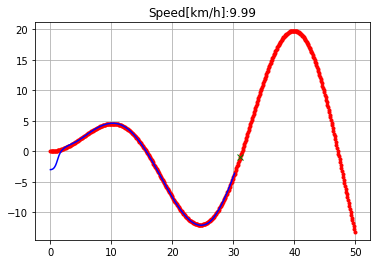

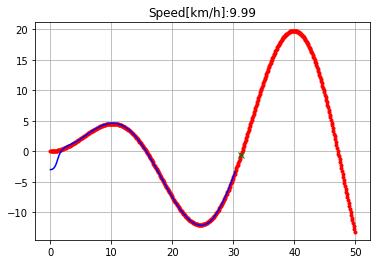

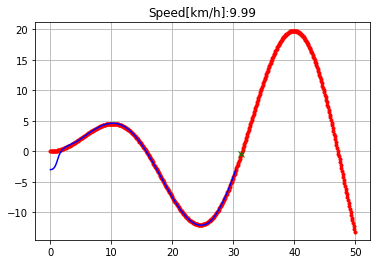

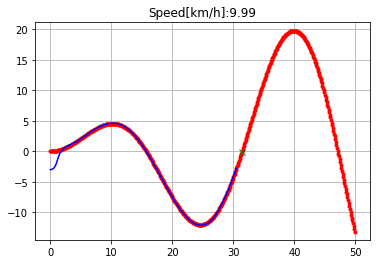

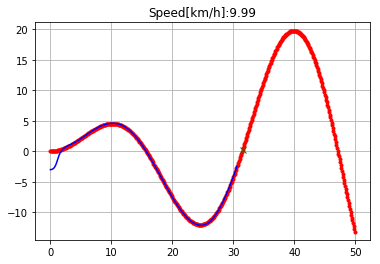

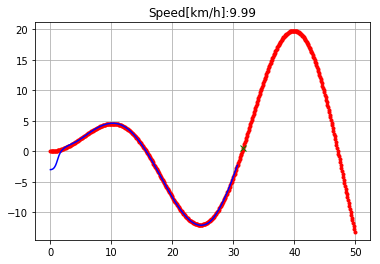

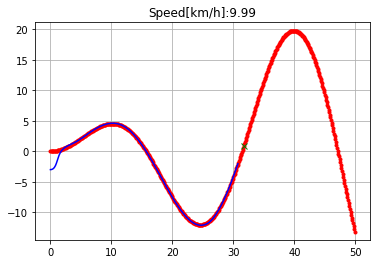

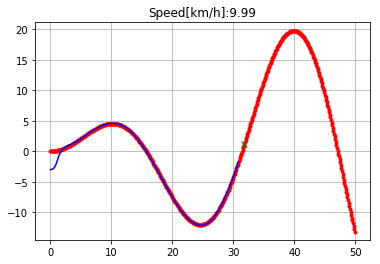

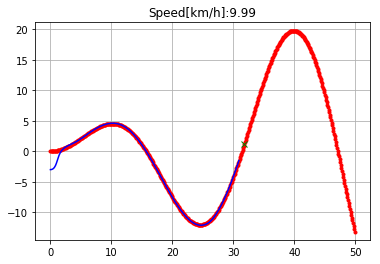

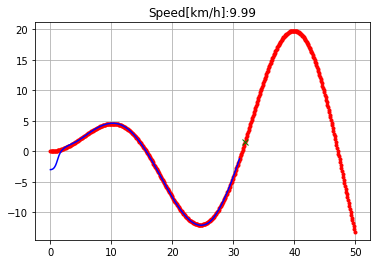

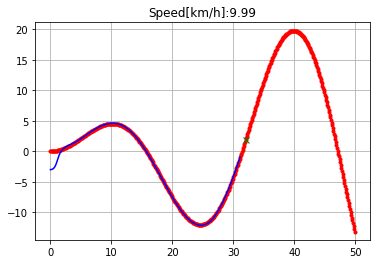

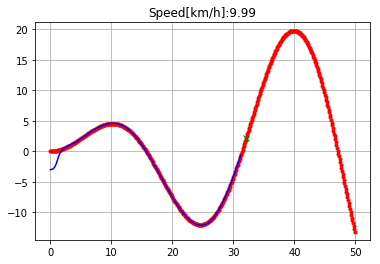

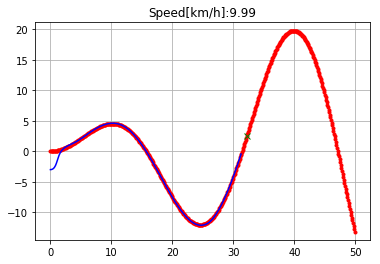

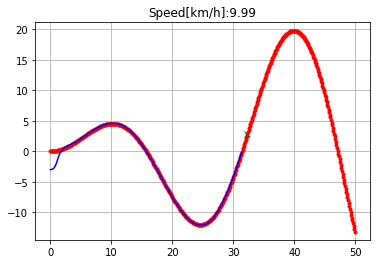

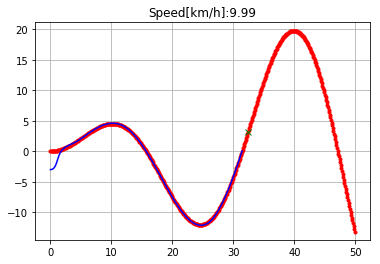

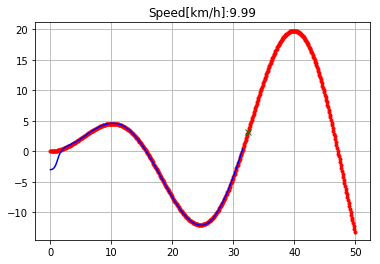

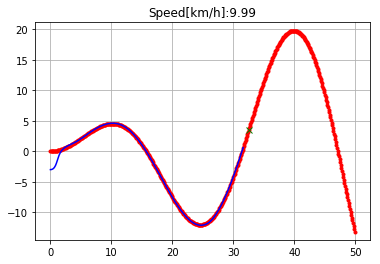

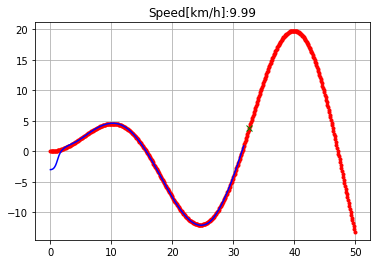

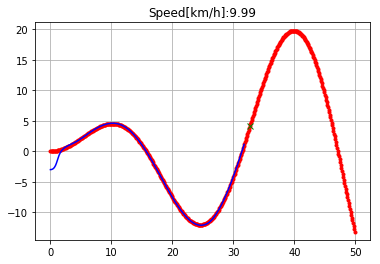

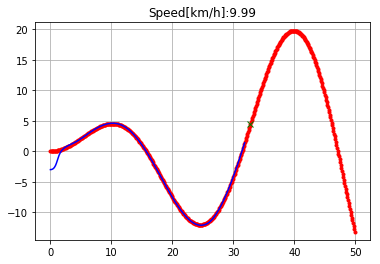

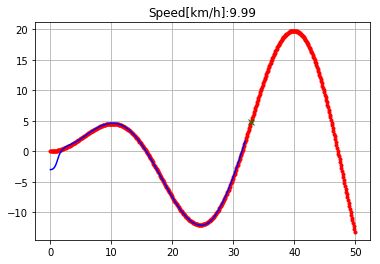

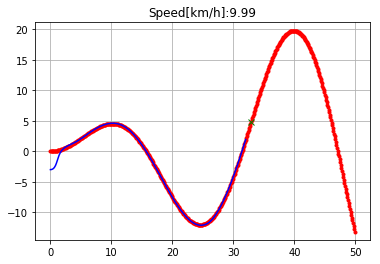

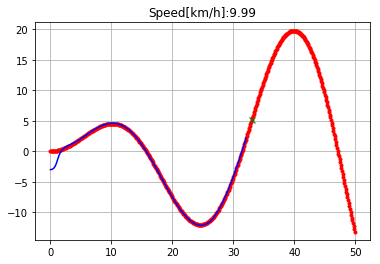

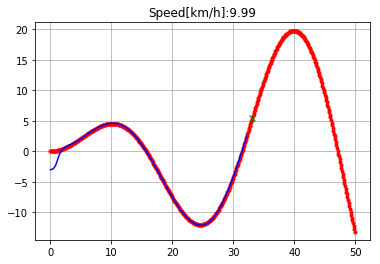

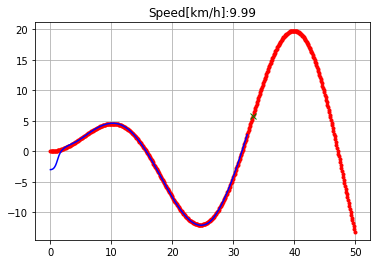

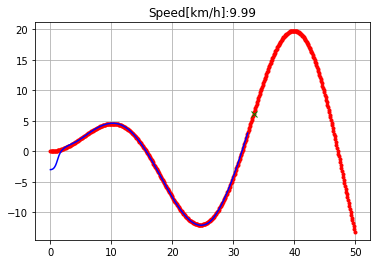

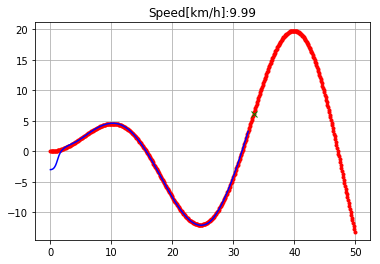

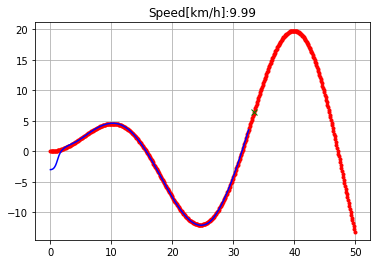

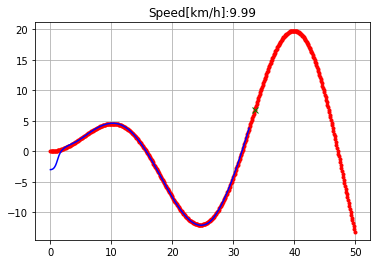

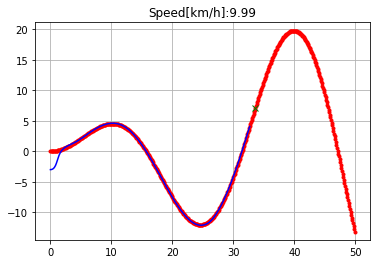

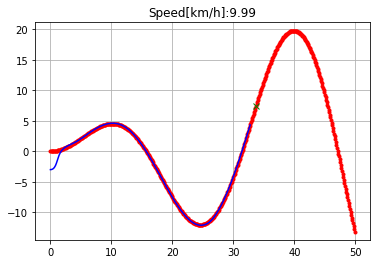

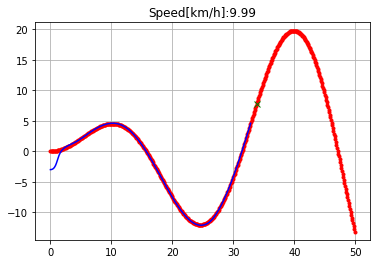

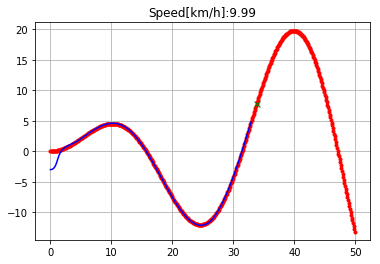

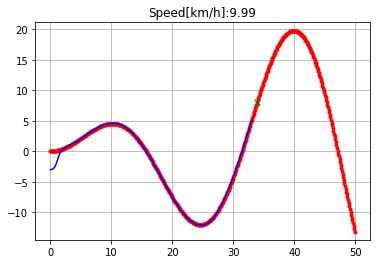

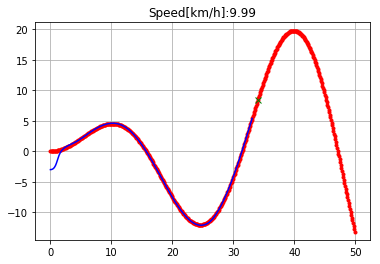

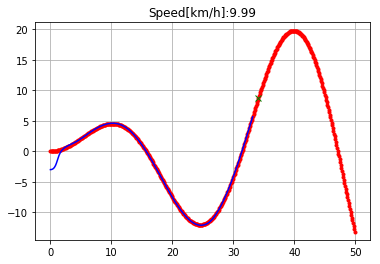

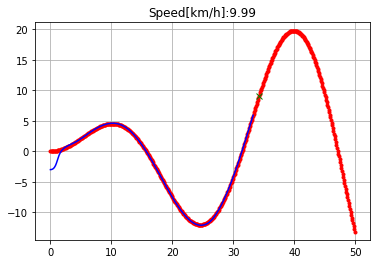

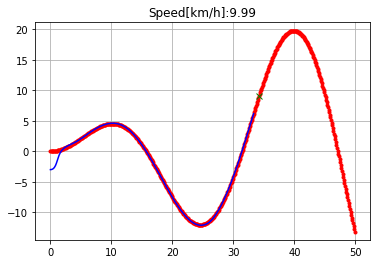

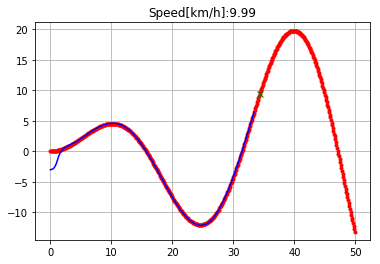

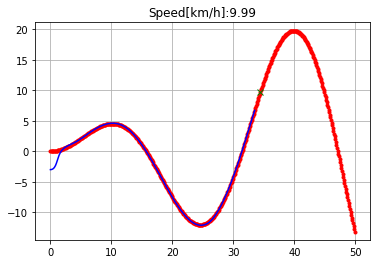

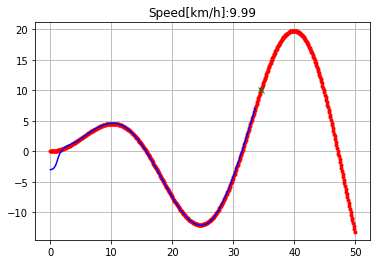

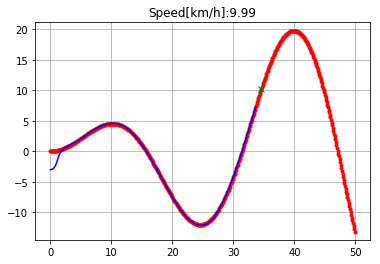

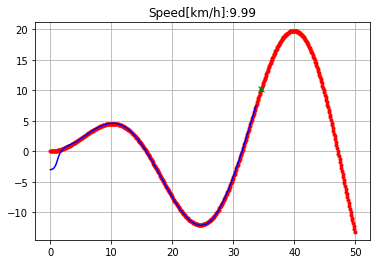

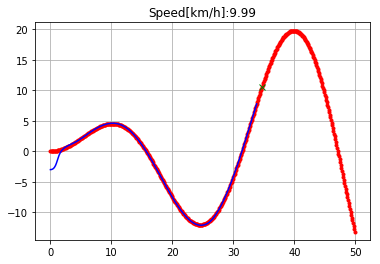

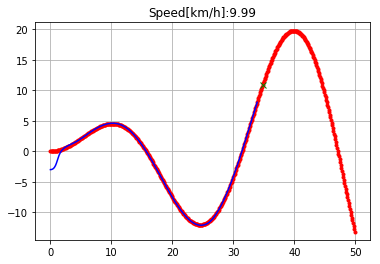

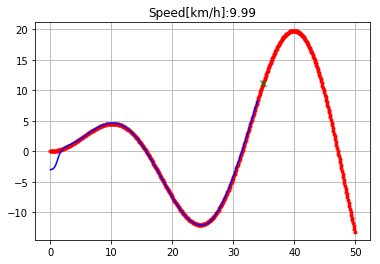

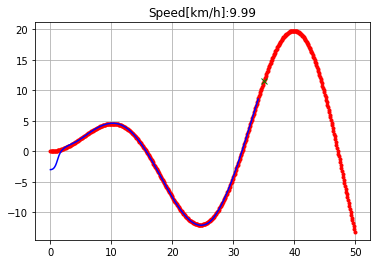

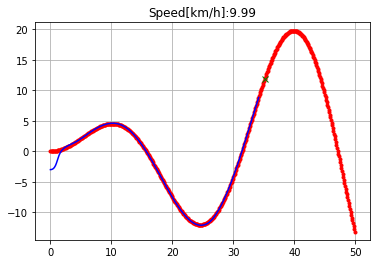

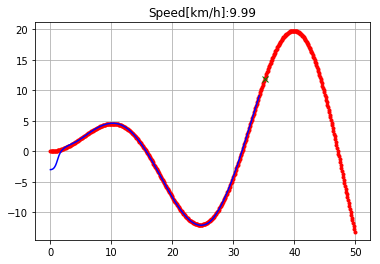

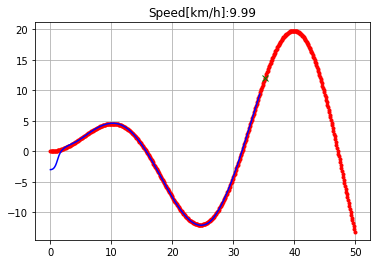

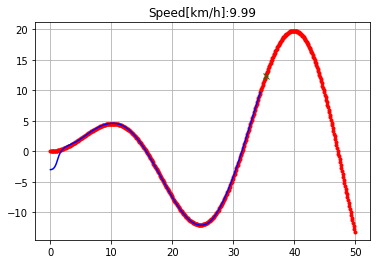

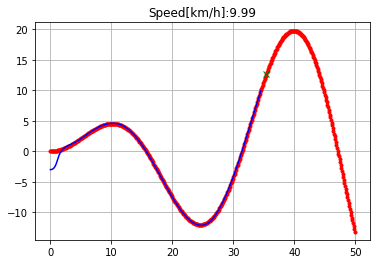

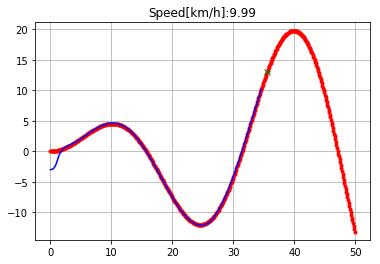

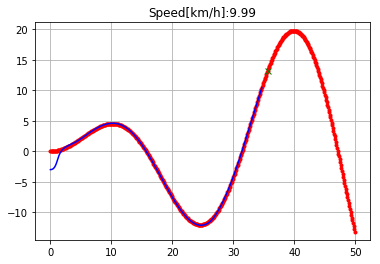

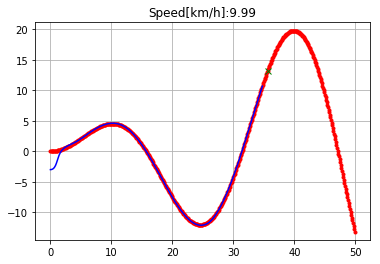

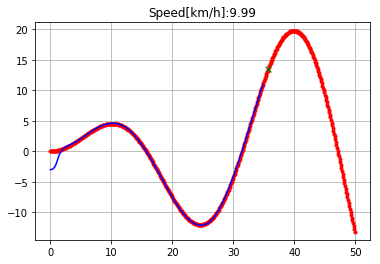

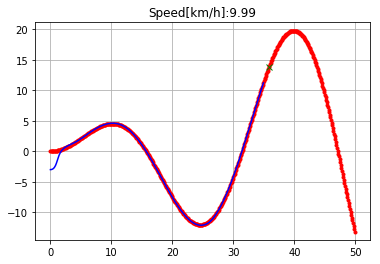

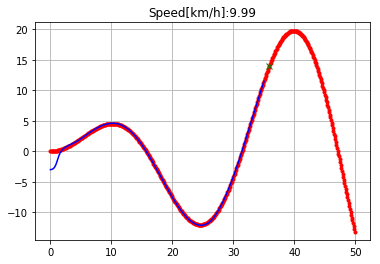

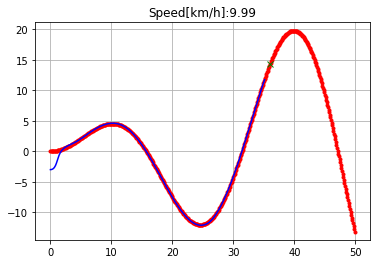

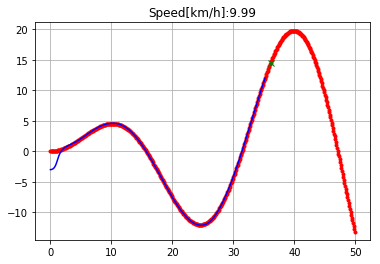

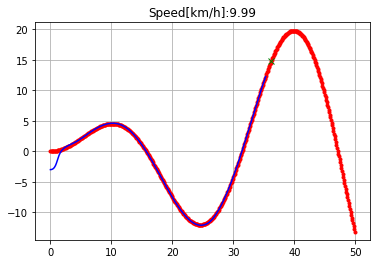

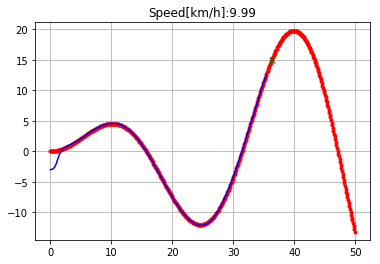

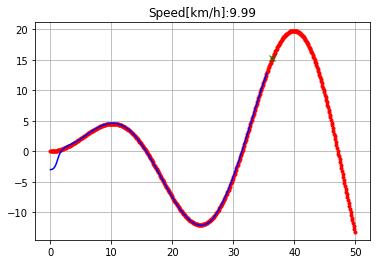

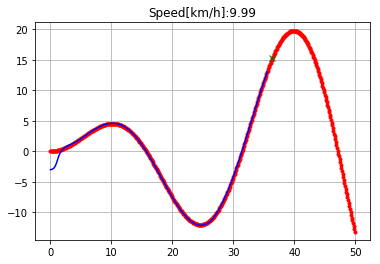

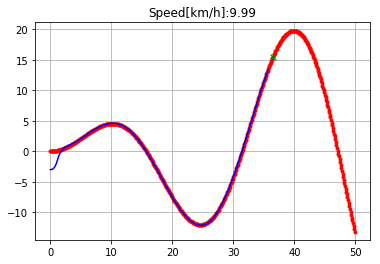

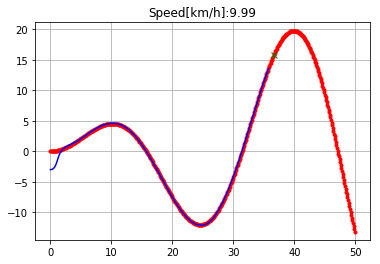

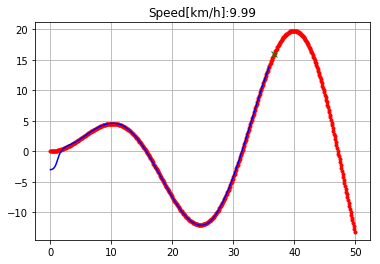

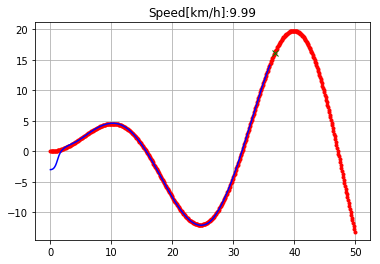

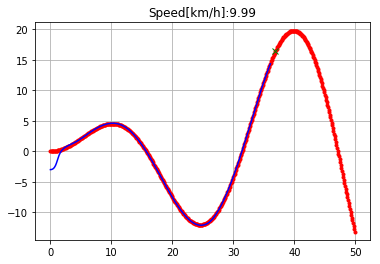

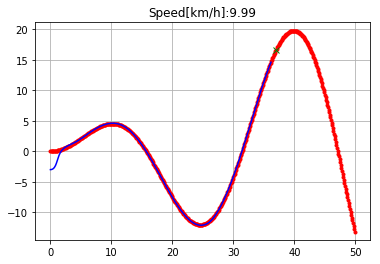

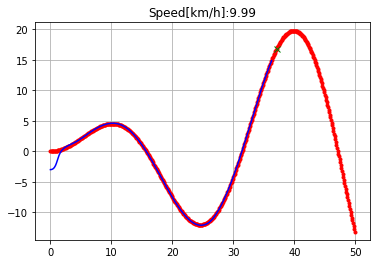

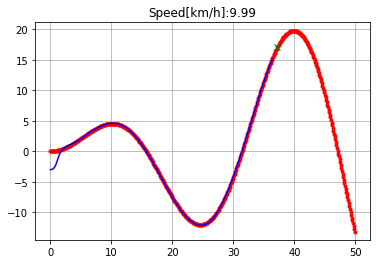

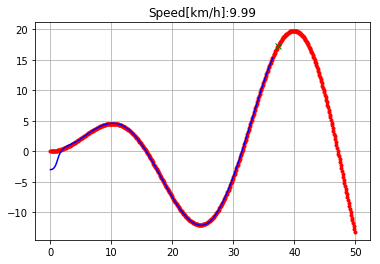

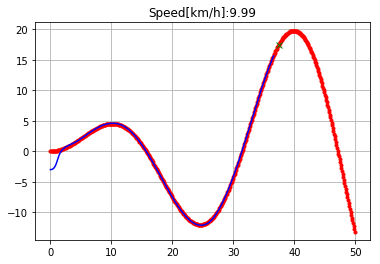

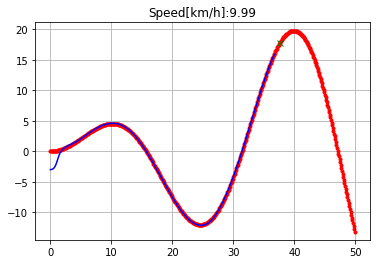

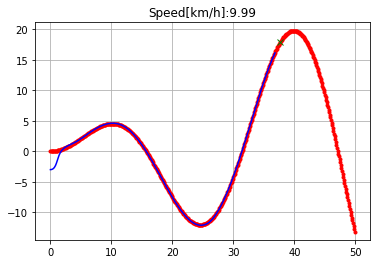

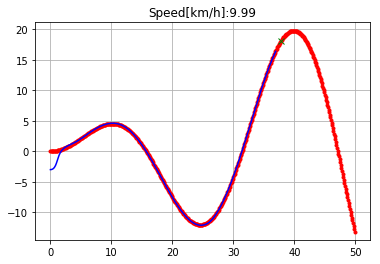

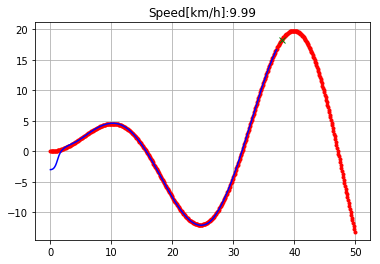

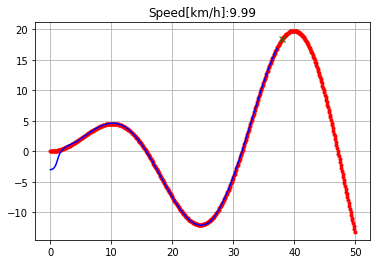

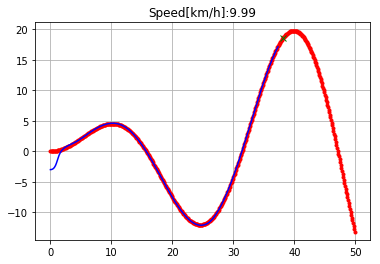

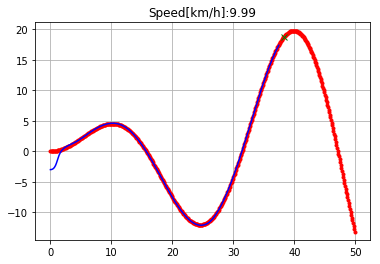

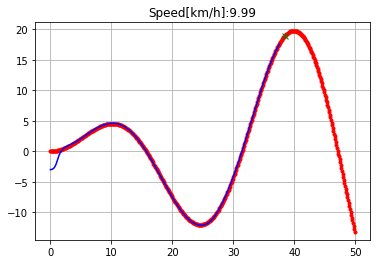

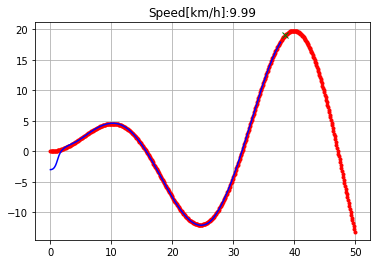

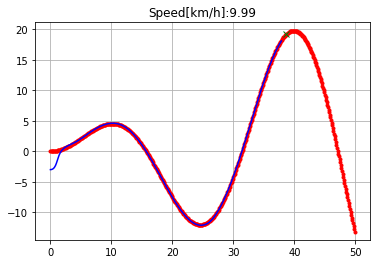

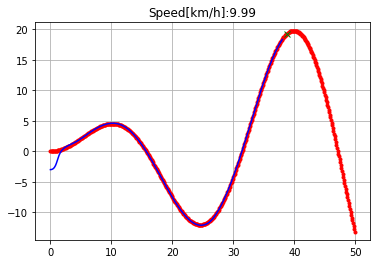

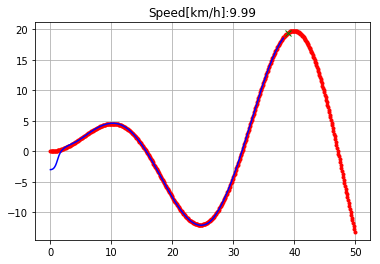

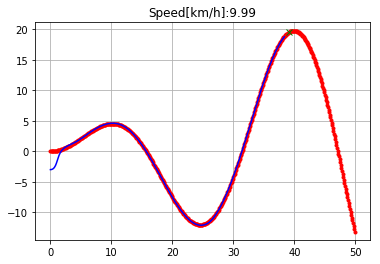

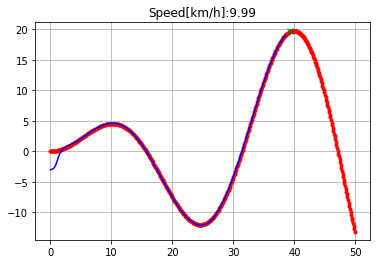

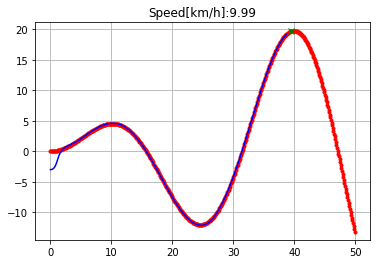

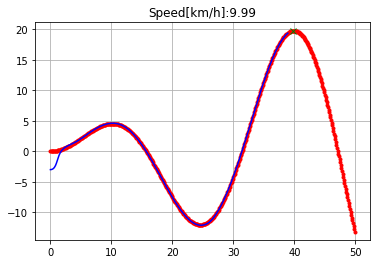

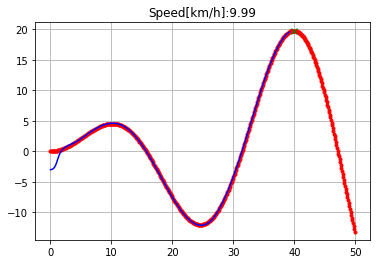

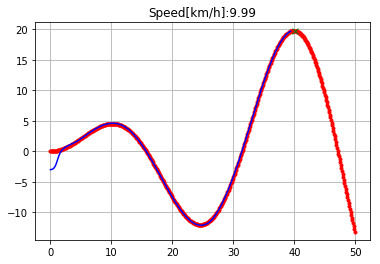

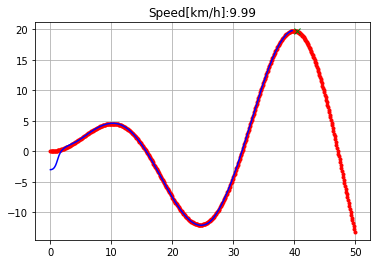

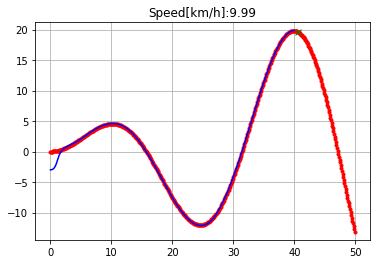

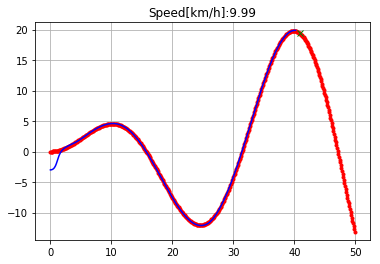

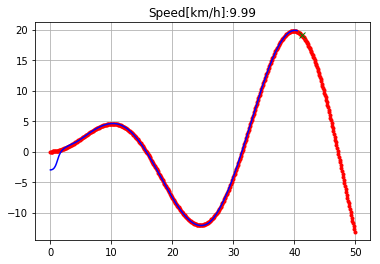

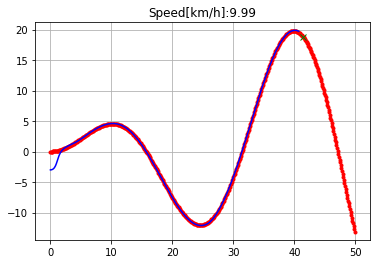

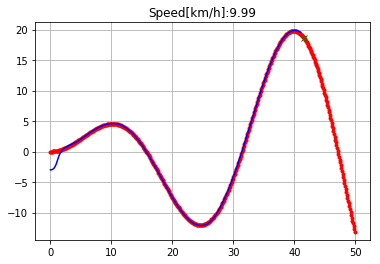

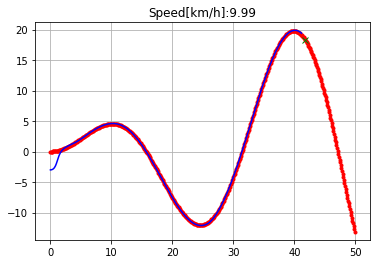

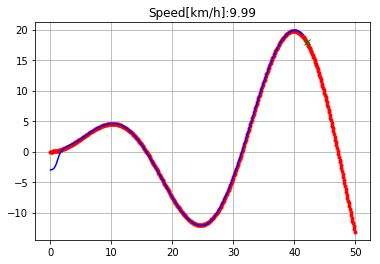

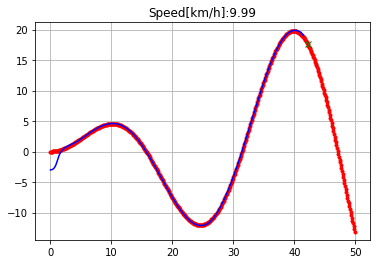

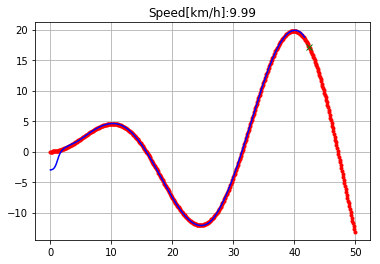

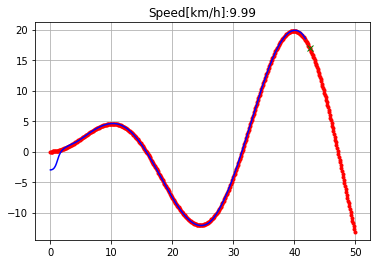

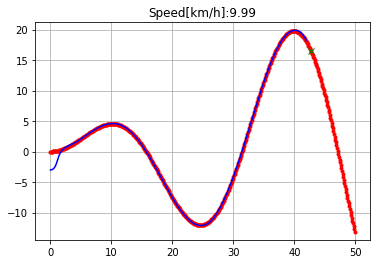

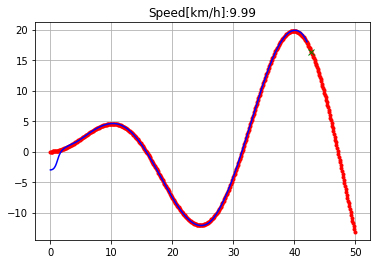

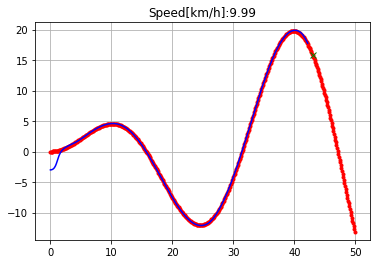

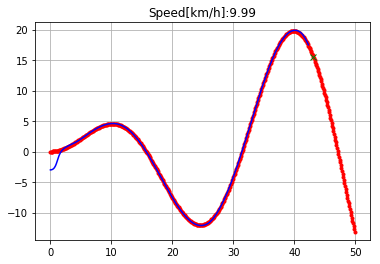

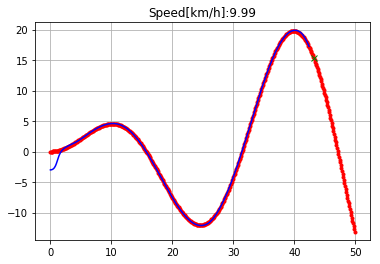

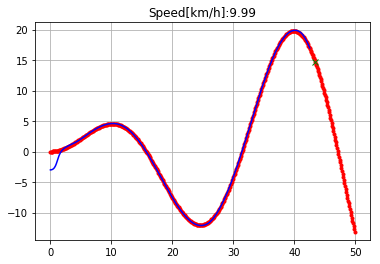

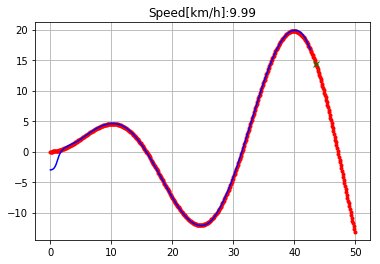

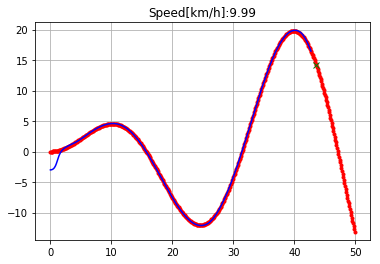

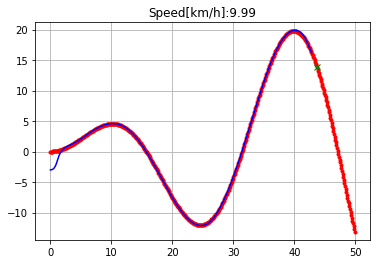

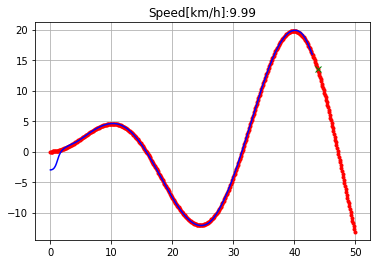

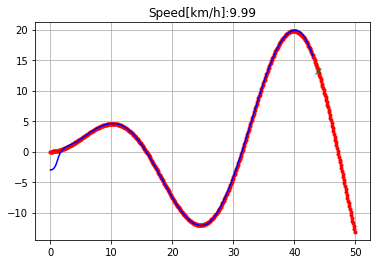

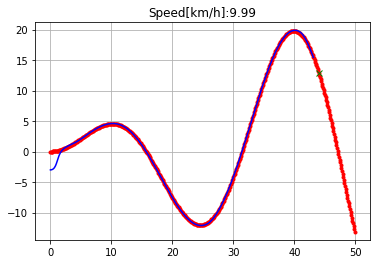

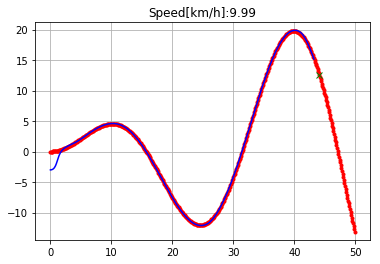

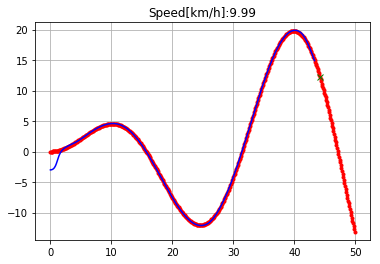

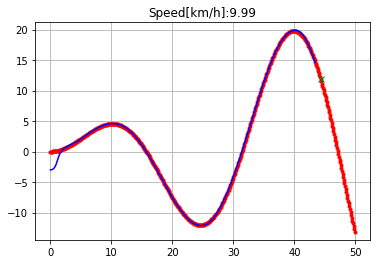

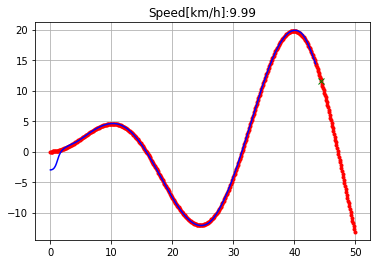

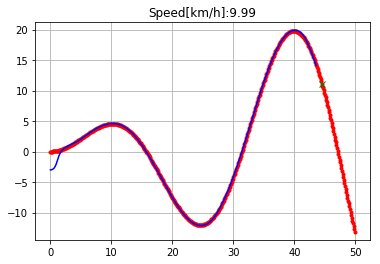

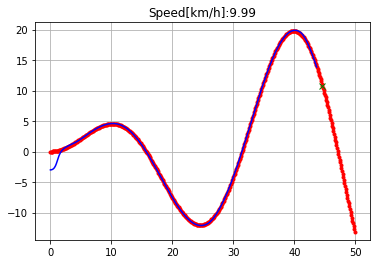

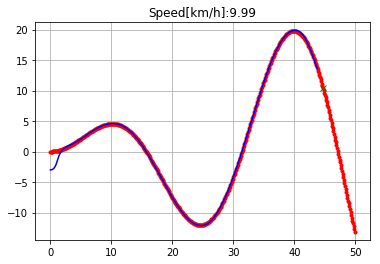

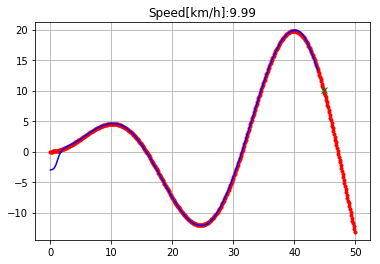

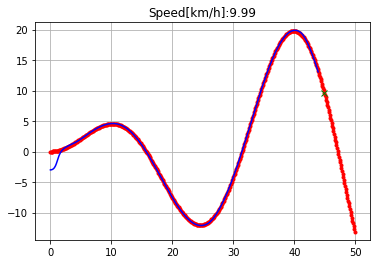

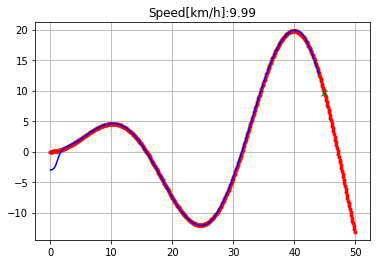

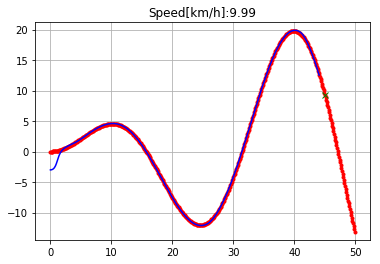

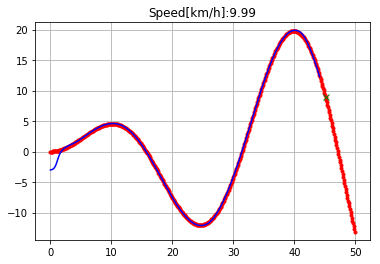

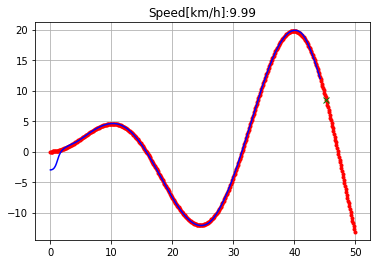

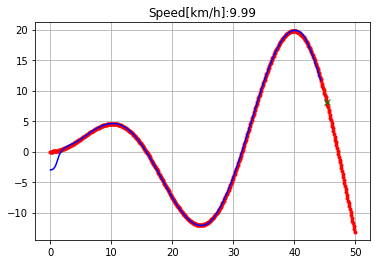

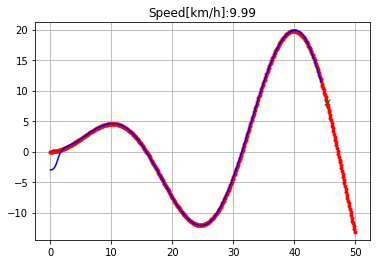

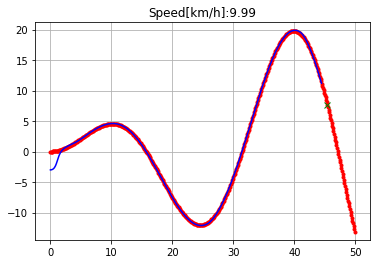

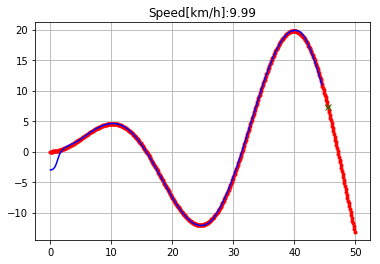

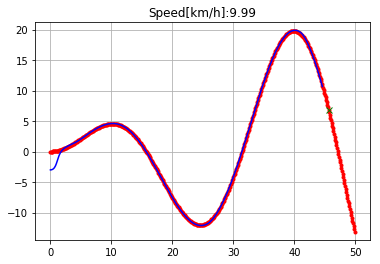

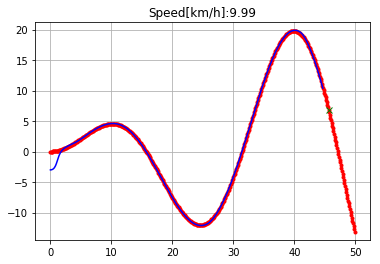

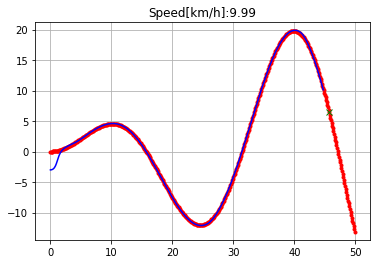

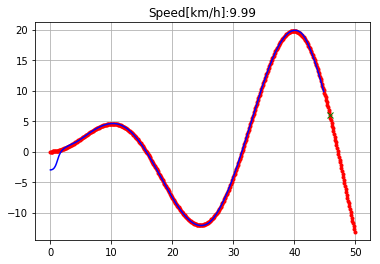

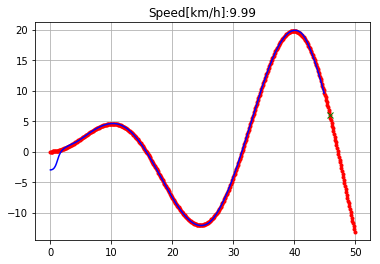

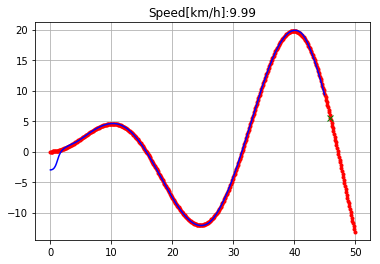

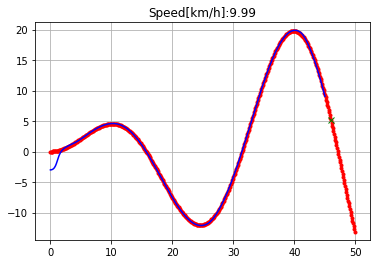

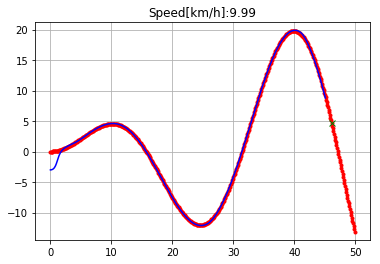

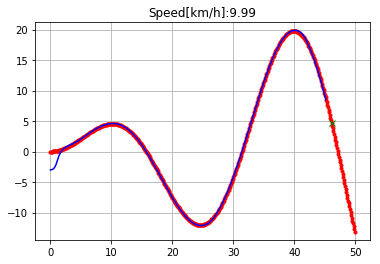

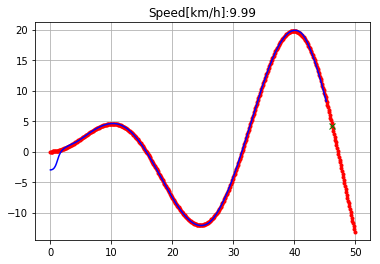

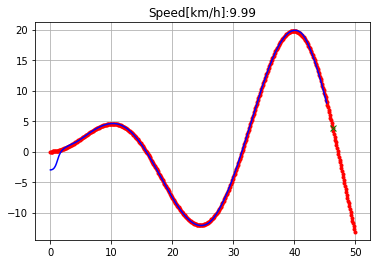

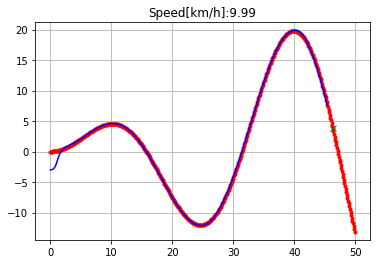

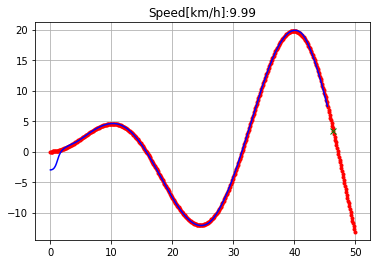

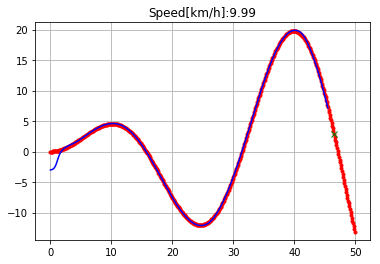

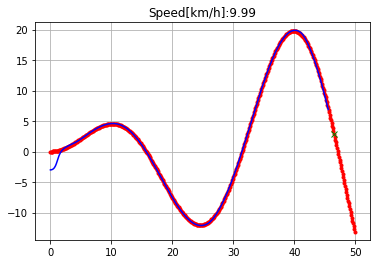

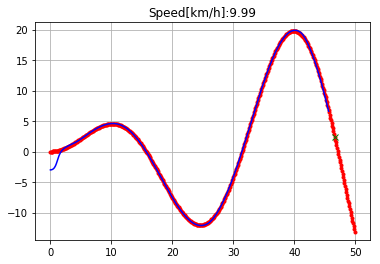

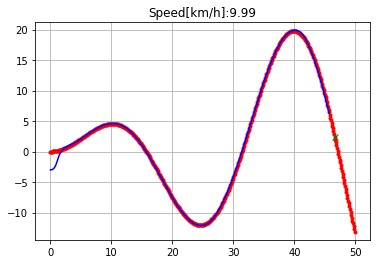

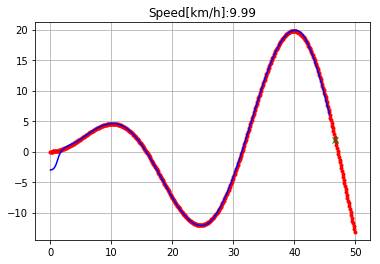

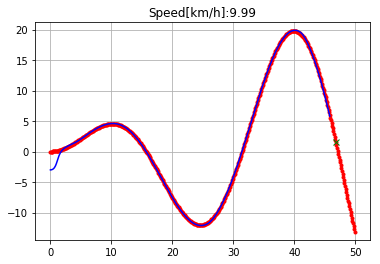

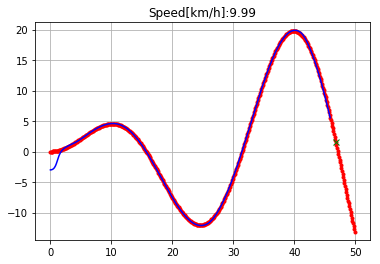

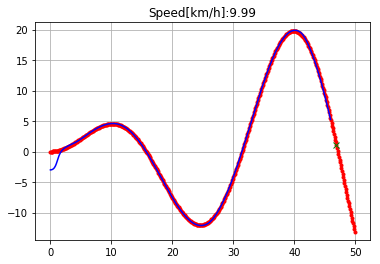

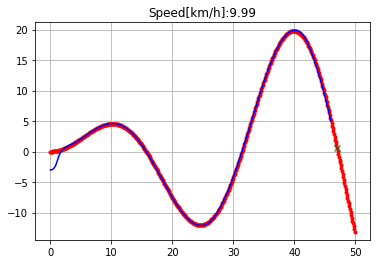

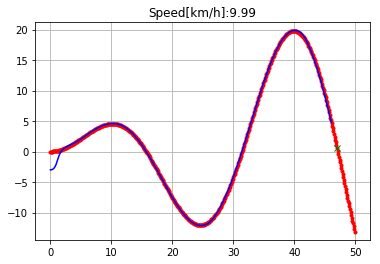

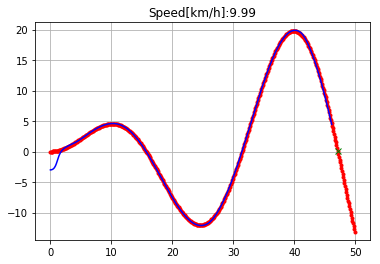

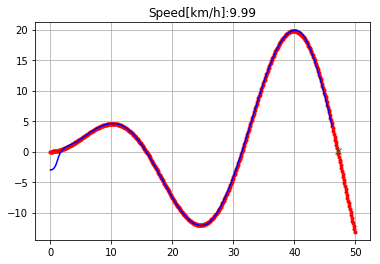

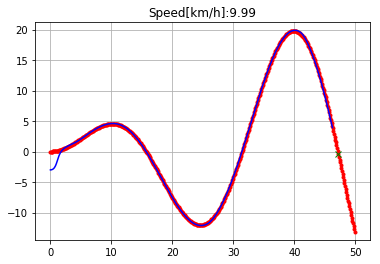

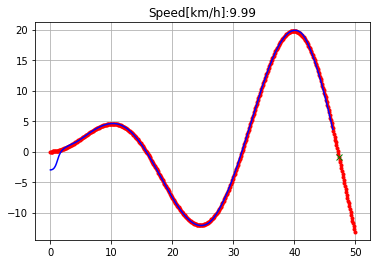

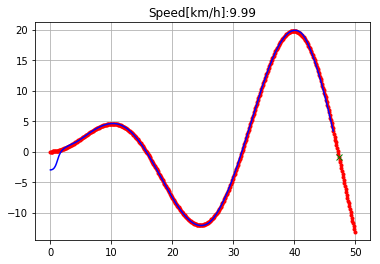

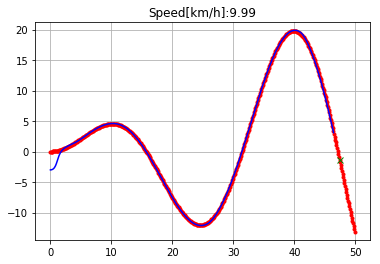

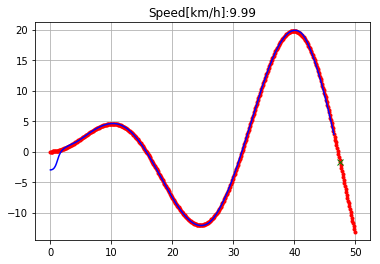

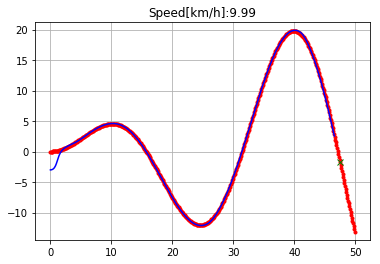

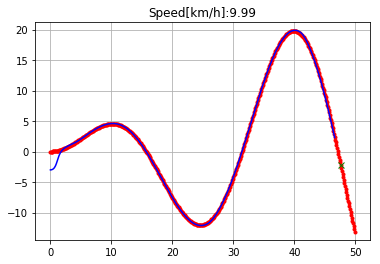

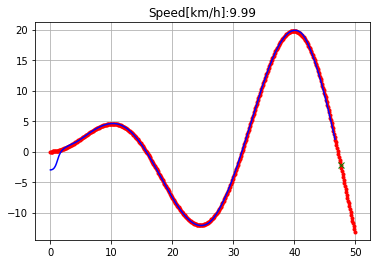

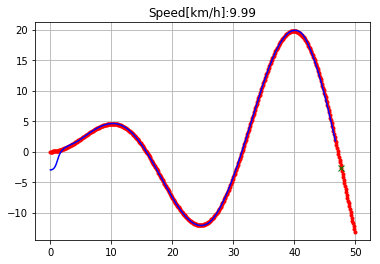

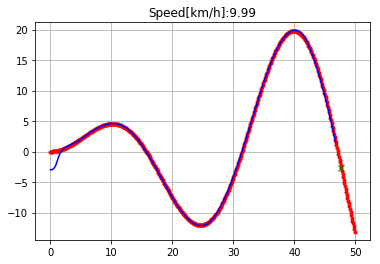

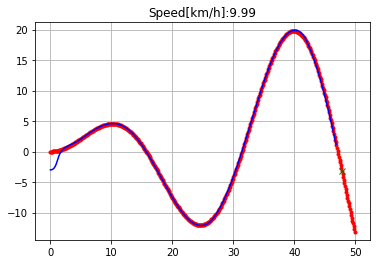

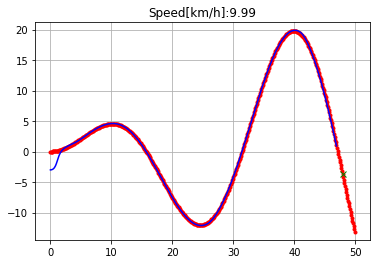

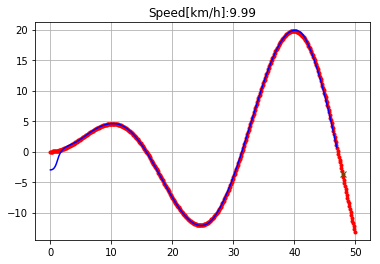

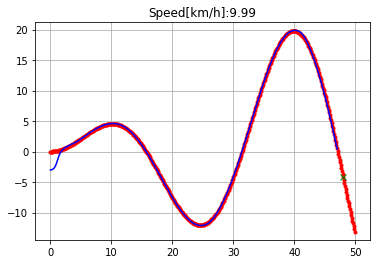

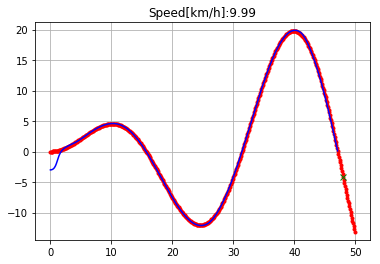

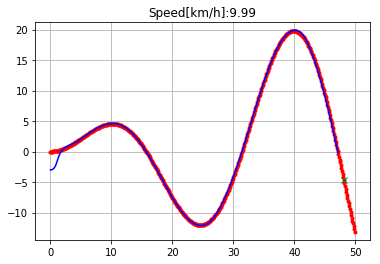

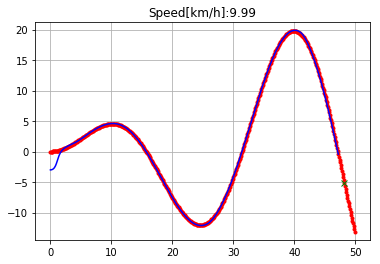

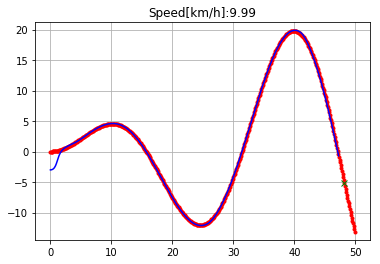

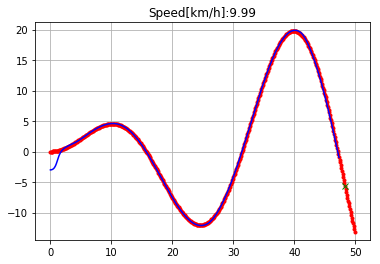

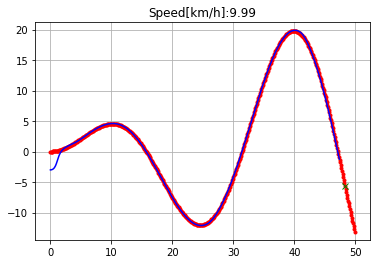

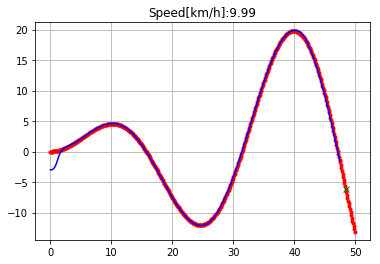

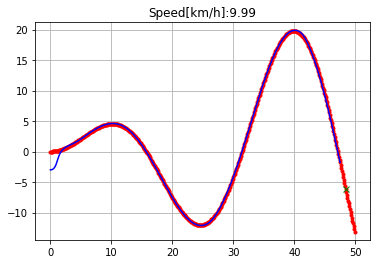

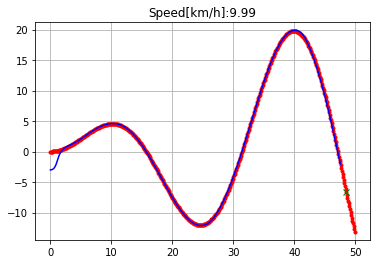

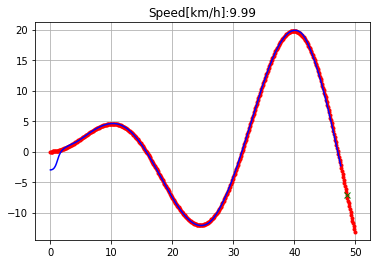

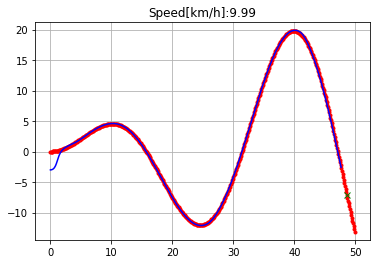

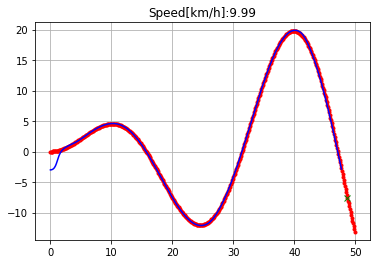

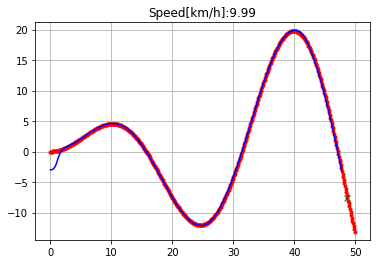

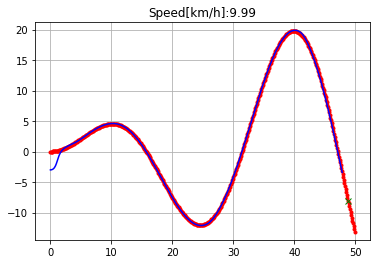

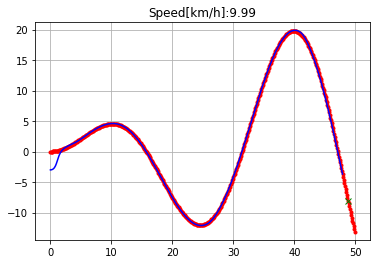

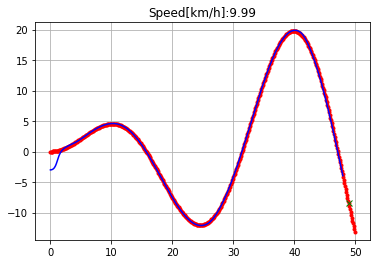

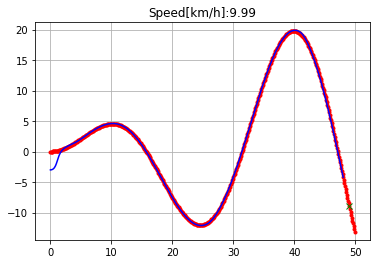

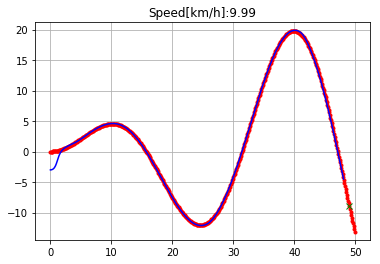

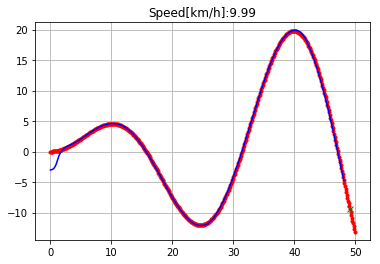

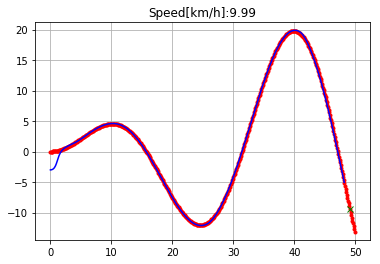

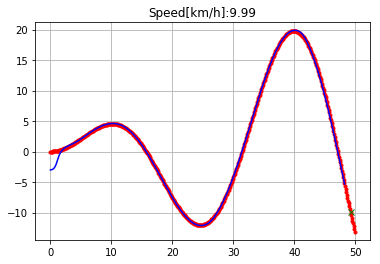

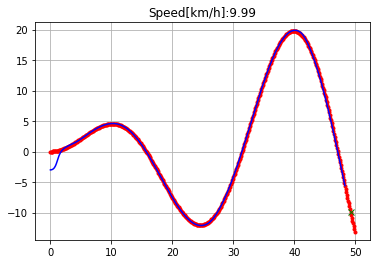

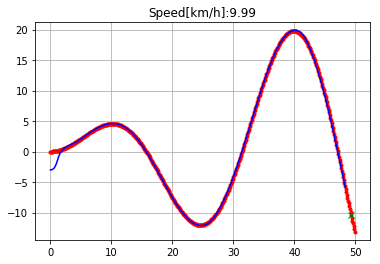

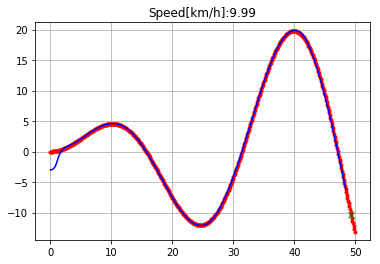

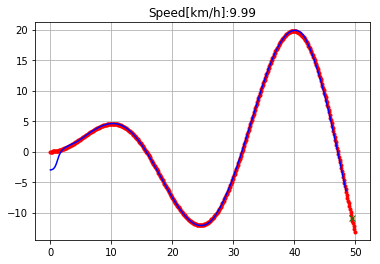

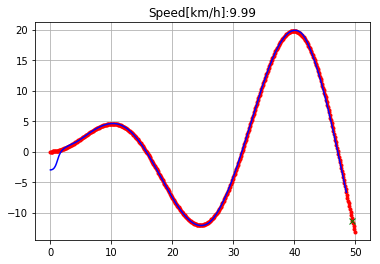

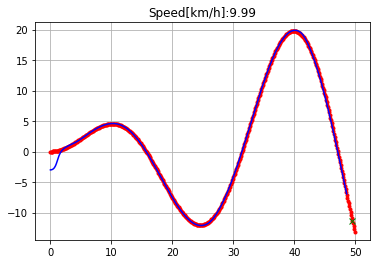

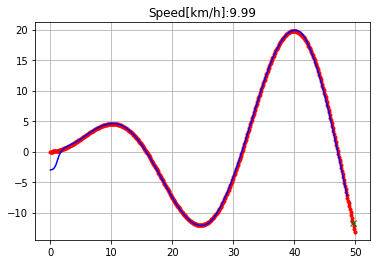

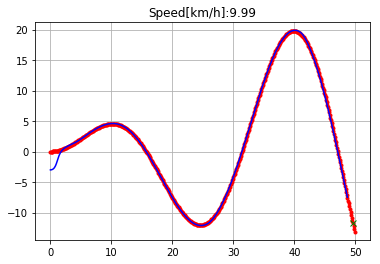

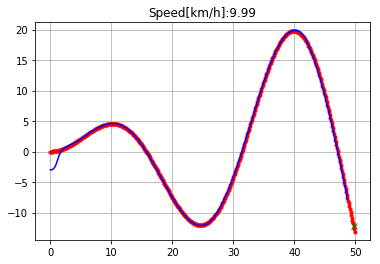

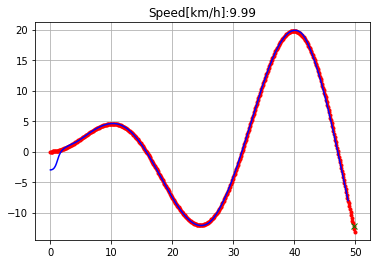

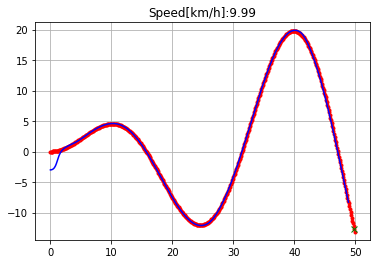

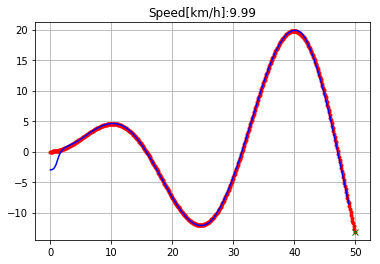

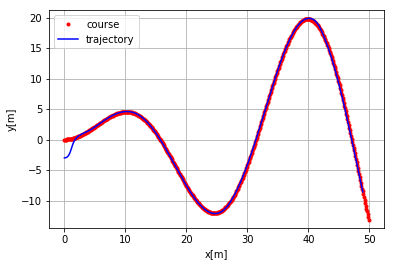

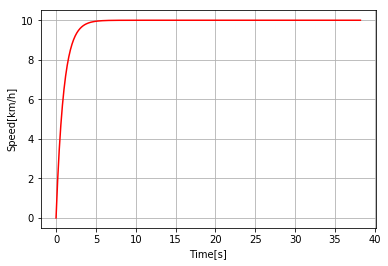

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt

k = 0.1  # look forward gain
Lfc = 1.0  # look-ahead distance
Kp = 1.0  # speed propotional gain
dt = 0.1  # [s]
L = 2.9  # [m] wheel base of vehicle


show_animation = True


class State:

    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v


def update(state, a, delta):

    state.x = state.x + state.v * math.cos(state.yaw) * dt
    state.y = state.y + state.v * math.sin(state.yaw) * dt
    state.yaw = state.yaw + state.v / L * math.tan(delta) * dt
    state.v = state.v + a * dt

    return state


def PIDControl(target, current):
    a = Kp * (target - current)

    return a


def pure_pursuit_control(state, cx, cy, pind):

    ind = calc_target_index(state, cx, cy)

    if pind >= ind:
        ind = pind

    if ind < len(cx):
        tx = cx[ind]
        ty = cy[ind]
    else:
        tx = cx[-1]
        ty = cy[-1]
        ind = len(cx) - 1

    alpha = math.atan2(ty - state.y, tx - state.x) - state.yaw

    if state.v < 0:  # back
        alpha = math.pi - alpha

    Lf = k * state.v + Lfc

    delta = math.atan2(2.0 * L * math.sin(alpha) / Lf, 1.0)

    return delta, ind


def calc_target_index(state, cx, cy):

    # search nearest point index
    dx = [state.x - icx for icx in cx]
    dy = [state.y - icy for icy in cy]
    d = [abs(math.sqrt(idx ** 2 + idy ** 2)) for (idx, idy) in zip(dx, dy)]
    ind = d.index(min(d))
    L = 0.0

    Lf = k * state.v + Lfc

    # search look ahead target point index
    while Lf > L and (ind + 1) < len(cx):
        dx = cx[ind + 1] - cx[ind]
        dy = cx[ind + 1] - cx[ind]
        L += math.sqrt(dx ** 2 + dy ** 2)
        ind += 1

    return ind


def main():
    #  target course
    cx = np.arange(0, 50, 0.1)
    cy = [math.sin(ix / 5.0) * ix / 2.0 for ix in cx]

    target_speed = 10.0 / 3.6  # [m/s]

    T = 100.0  # max simulation time

    # initial state
    state = State(x=-0.0, y=-3.0, yaw=0.0, v=0.0)

    lastIndex = len(cx) - 1
    time = 0.0
    x = [state.x]
    y = [state.y]
    yaw = [state.yaw]
    v = [state.v]
    t = [0.0]
    target_ind = calc_target_index(state, cx, cy)

    while T >= time and lastIndex > target_ind:
        ai = PIDControl(target_speed, state.v)
        di, target_ind = pure_pursuit_control(state, cx, cy, target_ind)
        state = update(state, ai, di)

        time = time + dt

        x.append(state.x)
        y.append(state.y)
        yaw.append(state.yaw)
        v.append(state.v)
        t.append(time)

        if show_animation:
            plt.cla()
            plt.plot(cx, cy, ".r", label="course")
            plt.plot(x, y, "-b", label="trajectory")
            plt.plot(cx[target_ind], cy[target_ind], "xg", label="target")
            plt.axis("equal")
            plt.grid(True)
            plt.title("Speed[km/h]:" + str(state.v * 3.6)[:4])
            plt.pause(0.001)

    # Test
    assert lastIndex >= target_ind, "Cannot goal"

    if show_animation:
        plt.plot(cx, cy, ".r", label="course")
        plt.plot(x, y, "-b", label="trajectory")
        plt.legend()
        plt.xlabel("x[m]")
        plt.ylabel("y[m]")
        plt.axis("equal")
        plt.grid(True)

        flg, ax = plt.subplots(1)
        plt.plot(t, [iv * 3.6 for iv in v], "-r")
        plt.xlabel("Time[s]")
        plt.ylabel("Speed[km/h]")
        plt.grid(True)
        plt.show()


if __name__ == '__main__':
    print("Pure pursuit path tracking simulation start")
    main()